In [1]:
import pandas as pd

In [2]:
raw_data = pd.read_csv('Stocks/' + 'baba.us' + '.txt')
raw_data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2014-09-19,92.70,99.70,89.95,93.89,271831625,0
1,2014-09-22,92.70,92.95,89.50,89.89,66628862,0
2,2014-09-23,89.00,90.48,86.62,87.17,38984872,0
3,2014-09-24,88.47,90.57,87.22,90.57,32016559,0
4,2014-09-25,91.09,91.50,88.50,88.92,28584828,0


**Add Bloomberg ref info to create ticker lookup table**

In [3]:
def bbg_ref():
    
    tickers = pd.DataFrame(columns=['file_name','ticker','year_last', 'n_datapoints'])

    from os import listdir
    from os.path import isfile, join

    mypath = 'Stocks/'

    tickers['file_name'] = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    tickers['ticker'] = tickers['file_name'].apply(lambda i: i.replace('.txt', '').replace('.',' ').upper() + " Equity") 

    for i in range(len(tickers)):
        raw_data = pd.read_csv('Stocks/' + tickers.iloc[i]['file_name'])
        year = raw_data.iloc[-1]['Date'][:4]
        n_datapoints = len(raw_data)
        tickers.loc[i,'year_last'] = year
        tickers.loc[i,'n_datapoints'] = n_datapoints

        tickers['year_last'] = tickers['year_last'].astype(int)
        tickers = tickers[~tickers['file_name'].str.contains('_')]
        tickers = tickers[~tickers['file_name'].str.contains('-')]
    
    import pdblp
    
    con = pdblp.BCon(debug=True, port=8194, timeout=5000)

    tickers_ = tickers[(tickers['year_last']>=2016) & (tickers['n_datapoints']>=250)]

    con.start()

    ref_data = pd.DataFrame()

    for ticker in tickers_['ticker'].tolist():
        try:
            ref_data = ref_data.append(con.ref(ticker, ['COUNTRY_ISO','COUNTRY_FULL_NAME','SHORT_NAME','INDUSTRY_SECTOR','GICS_SECTOR_NAME','INDUSTRY_GROUP','GICS_INDUSTRY_GROUP_NAME']))
        except:
            True
    ref_data_copy = ref_data
    ref_data.pivot(index='ticker',columns='field',values='value')
    tickers = tickers.merge(ref_data.pivot(index='ticker',columns='field',values='value'),how = 'left', on='ticker')
    tickers = tickers[['file_name', 'ticker', 'SHORT_NAME', 'COUNTRY_ISO', 'COUNTRY_FULL_NAME',
                   'GICS_INDUSTRY_GROUP_NAME', 'GICS_SECTOR_NAME', 'INDUSTRY_GROUP', 
                   'INDUSTRY_SECTOR', 'year_last', 'n_datapoints']]
    
    tickers.to_csv('tickers_lookup.csv',index=False)

## Feature extraction

In [4]:
from create_features import create_features

In [5]:
features, raw_data = create_features('ba.us',21)

In [6]:
features.shape

(12031, 11)

In [7]:
features.columns

Index(['Open', 'pct_overnight', 'pct_close', 'pct_close_sigma_q_tw',
       'pct_close_sigma_tw', 'avg_return_q_tw', 'avg_return_tw',
       'perctentile_q_tw', 'perctentile_tw', 'pct_volume_sigma_q_tw',
       'pct_volume_sigma_tw'],
      dtype='object')

In [8]:
def sample_data(trading_window,features, raw_data):
    #Keep random sample of size trading_window  
    import numpy as np
    i = np.random.randint(0,high=len(features)-trading_window-1)
    features = features.iloc[i:i+trading_window,] 
    prices= raw_data.loc[features.index,]
    return features, prices

In [9]:
#Test
features, prices = sample_data(5, features, raw_data)

## Reinforcement Learning

In [10]:
ticker = 'ba.us'
trading_window = 21

In [11]:
#Import raw price data and calculate features 
features, raw_data = create_features(ticker,trading_window)

#Only keep data after 2007
features['Year'] = pd.to_datetime(features.index.values).year
features = features.loc[features['Year']>2007]
raw_data = raw_data.loc[features.index]

#Split training & testing sets
train_max_year = 2016
features_train = features.loc[features['Year']<train_max_year]
raw_data_train = raw_data.loc[features_train.index]

features_test = features.loc[features['Year']>=train_max_year]
raw_data_test = raw_data.loc[features_test.index]

#Remove Year column from features
features.drop(['Year'], inplace = True, axis = 1)
features_train = features_train.drop(['Year'], axis = 1)
features_test = features_test.drop(['Year'], axis = 1)

In [12]:
print('# of total samples: ' + str(features.shape[0]))
print('# of training samples: ' + str(features_train.shape[0]))
print('# of test samples: ' + str(features_test.shape[0]))

# of total samples: 2464
# of training samples: 1994
# of test samples: 470


### Training

Set up environment for training:

In [13]:
import gym
import gym_market
import numpy as np
import imp

pos_limit = 2
trading_freq = 1

stop_loss_thres = 0.98
take_prof_thres = 1.04

kwargs = {'pos_limit': pos_limit,
                  'trading_window': trading_window,
                  'trading_freq': trading_freq,
                  'ticker': ticker,
                  'stop_loss_thres': stop_loss_thres,
                  'take_prof_thres': take_prof_thres,
                  'features': features_train, 
                  'raw_data':raw_data_train}

env = gym.make('market-v0', **kwargs)

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

Number of possible actions: 3


C:\Users\Alex\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Test environment:

In [14]:
actions = [] # actions that the agent selects
rewards = [] # obtained rewards
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    state, reward, done, info_log = env.step(action) 
    rewards.append(reward)
    actions.append(action)
    if done:
        break
        
print('Actions:', actions)
print('Rewards:', rewards)
print('Return:', info_log['total_return'])

Actions: [0, 1, 1, 0, 2, 2, 0, 2, 0, 0, 2, 2, 1, 1, 0, 1, 2, 1, 2, 2, 0]
Rewards: [-0.65, -1.55, -1.62, 0.22999999999999998, 0.32999999999999996, 0.26, -0.78, -1.74, -0.89, -1.04, 0.20999999999999996, -1.86, 1.1400000000000001, 0.08999999999999997, -0.9299999999999999, 0.0, -1.98, -0.030000000000000027, -1.04, -0.08999999999999997, -1.1099999999999999]
Return: 0.9800110378070448


In [15]:
plt_df = info_log['prices']
plt_df['Trades'] = info_log['trades']
plt_df['Pos'] = info_log['pos']
plt_df['Actions'] = info_log['actions']
plt_df.to_clipboard()

Neural net architecture:

In [16]:
import tensorflow as tf 

class QNetwork():
    def __init__(self, learning_rate=0.01, state_size=19, 
                 action_size=3, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

Memory:

In [17]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

Hyperparameters:

In [38]:
train_episodes = 3000         # max number of episodes to learn from
max_steps = 200               # max steps in an episode
gamma = 0.7                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0005         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [39]:
#tf.reset_default_graph()
from tensorflow.python.framework import ops
ops.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, state_size=features.shape[1]+2, learning_rate=learning_rate)

Populate memory:

In [40]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, info_log = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, info_log = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        state = env.reset()
        # Take one random step to get the pole and cart moving
        #state, reward, done, info_log = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

Train agent:

In [41]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
total_returns_list = []
loss_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step)
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()    
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                #if ep > 1500:
                    #print("Q_s: "+str(Qs))
                action = np.argmax(Qs)
            #print(action)if ep > 1500 else False
            # Take action, get new state and reward
            next_state, reward, done, info_log = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p),
                      'Total return: {:.2f}'.format(info_log['total_return']))
                rewards_list.append((ep, total_reward))
                total_returns_list.append((ep, info_log['total_return']))
                loss_list.append((ep, loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                state = env.reset()
                #state, reward, done, info_log = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/trader.ckpt")

Episode: 1 Total reward: -10.6 Training loss: 16.3060 Explore P: 0.9979 Total return: 0.91
Episode: 2 Total reward: -16.93 Training loss: 1.7210 Explore P: 0.9959 Total return: 0.96
Episode: 3 Total reward: -15.020000000000001 Training loss: 0.5656 Explore P: 0.9938 Total return: 0.96
Episode: 4 Total reward: -14.260000000000002 Training loss: 0.5783 Explore P: 0.9917 Total return: 1.06
Episode: 5 Total reward: -10.279999999999998 Training loss: 0.7731 Explore P: 0.9897 Total return: 1.09
Episode: 6 Total reward: -9.859999999999998 Training loss: 0.3960 Explore P: 0.9876 Total return: 1.07
Episode: 7 Total reward: -14.960000000000004 Training loss: 0.7926 Explore P: 0.9856 Total return: 1.03
Episode: 8 Total reward: -14.67 Training loss: 0.6221 Explore P: 0.9835 Total return: 0.94
Episode: 9 Total reward: -9.42 Training loss: 0.7834 Explore P: 0.9815 Total return: 1.05
Episode: 10 Total reward: -16.430000000000003 Training loss: 0.5602 Explore P: 0.9794 Total return: 0.97
Episode: 11 T

Episode: 86 Total reward: -12.260000000000002 Training loss: 0.8836 Explore P: 0.8364 Total return: 1.02
Episode: 87 Total reward: -14.17 Training loss: 0.7851 Explore P: 0.8347 Total return: 1.02
Episode: 88 Total reward: -7.080000000000001 Training loss: 0.6887 Explore P: 0.8330 Total return: 1.07
Episode: 89 Total reward: -21.599999999999998 Training loss: 0.6580 Explore P: 0.8312 Total return: 0.98
Episode: 90 Total reward: -18.000000000000004 Training loss: 0.6315 Explore P: 0.8295 Total return: 0.90
Episode: 91 Total reward: -16.47 Training loss: 0.5538 Explore P: 0.8278 Total return: 1.00
Episode: 92 Total reward: -17.73 Training loss: 0.9436 Explore P: 0.8261 Total return: 0.98
Episode: 93 Total reward: -15.920000000000002 Training loss: 1.2240 Explore P: 0.8244 Total return: 0.95
Episode: 94 Total reward: -12.209999999999999 Training loss: 1.0538 Explore P: 0.8227 Total return: 0.99
Episode: 95 Total reward: -13.919999999999998 Training loss: 0.3089 Explore P: 0.8209 Total ret

Episode: 171 Total reward: -12.959999999999999 Training loss: 0.8085 Explore P: 0.7013 Total return: 0.98
Episode: 172 Total reward: -10.24 Training loss: 0.5928 Explore P: 0.6999 Total return: 1.08
Episode: 173 Total reward: -7.09 Training loss: 0.7489 Explore P: 0.6984 Total return: 1.07
Episode: 174 Total reward: -12.009999999999998 Training loss: 0.9226 Explore P: 0.6970 Total return: 1.04
Episode: 175 Total reward: -10.24 Training loss: 0.5787 Explore P: 0.6955 Total return: 0.98
Episode: 176 Total reward: -11.339999999999998 Training loss: 0.7906 Explore P: 0.6941 Total return: 1.02
Episode: 177 Total reward: -13.670000000000002 Training loss: 0.9165 Explore P: 0.6927 Total return: 0.98
Episode: 178 Total reward: -13.100000000000001 Training loss: 0.3665 Explore P: 0.6912 Total return: 1.05
Episode: 179 Total reward: -23.61 Training loss: 0.8427 Explore P: 0.6898 Total return: 0.92
Episode: 180 Total reward: -13.730000000000002 Training loss: 0.7623 Explore P: 0.6884 Total return

Episode: 253 Total reward: -17.97 Training loss: 0.6621 Explore P: 0.5920 Total return: 1.01
Episode: 254 Total reward: -9.16 Training loss: 0.6724 Explore P: 0.5907 Total return: 1.04
Episode: 255 Total reward: -14.240000000000002 Training loss: 0.6463 Explore P: 0.5895 Total return: 0.95
Episode: 256 Total reward: -14.04 Training loss: 0.4972 Explore P: 0.5883 Total return: 1.03
Episode: 257 Total reward: -14.770000000000001 Training loss: 0.5109 Explore P: 0.5871 Total return: 1.06
Episode: 258 Total reward: -11.54 Training loss: 1.4086 Explore P: 0.5859 Total return: 0.98
Episode: 259 Total reward: -12.81 Training loss: 1.8689 Explore P: 0.5847 Total return: 0.96
Episode: 260 Total reward: -13.020000000000001 Training loss: 0.6444 Explore P: 0.5835 Total return: 0.94
Episode: 261 Total reward: -10.270000000000001 Training loss: 1.0323 Explore P: 0.5823 Total return: 1.03
Episode: 262 Total reward: -18.13 Training loss: 0.7030 Explore P: 0.5811 Total return: 0.99
Episode: 263 Total 

Episode: 337 Total reward: -24.39 Training loss: 0.9147 Explore P: 0.4978 Total return: 0.95
Episode: 338 Total reward: -12.409999999999998 Training loss: 0.8075 Explore P: 0.4968 Total return: 0.96
Episode: 339 Total reward: -14.36 Training loss: 0.7204 Explore P: 0.4958 Total return: 1.00
Episode: 340 Total reward: -24.240000000000002 Training loss: 1.7394 Explore P: 0.4948 Total return: 0.86
Episode: 341 Total reward: -17.32 Training loss: 0.7329 Explore P: 0.4938 Total return: 0.94
Episode: 342 Total reward: -11.619999999999997 Training loss: 0.5271 Explore P: 0.4928 Total return: 0.94
Episode: 343 Total reward: -11.599999999999998 Training loss: 0.3565 Explore P: 0.4917 Total return: 1.09
Episode: 344 Total reward: -10.889999999999999 Training loss: 0.7841 Explore P: 0.4907 Total return: 1.07
Episode: 345 Total reward: -22.740000000000002 Training loss: 0.5702 Explore P: 0.4897 Total return: 0.94
Episode: 346 Total reward: -15.11 Training loss: 1.1658 Explore P: 0.4887 Total retur

Episode: 422 Total reward: -14.73 Training loss: 0.4193 Explore P: 0.4181 Total return: 0.95
Episode: 423 Total reward: -10.16 Training loss: 0.6701 Explore P: 0.4172 Total return: 1.01
Episode: 424 Total reward: -10.81 Training loss: 1.3131 Explore P: 0.4164 Total return: 0.97
Episode: 425 Total reward: -17.56 Training loss: 0.5824 Explore P: 0.4155 Total return: 0.97
Episode: 426 Total reward: -16.66 Training loss: 0.6969 Explore P: 0.4147 Total return: 1.00
Episode: 427 Total reward: -14.150000000000002 Training loss: 1.1638 Explore P: 0.4138 Total return: 0.98
Episode: 428 Total reward: -11.69 Training loss: 0.4477 Explore P: 0.4130 Total return: 1.05
Episode: 429 Total reward: -16.410000000000004 Training loss: 0.6211 Explore P: 0.4121 Total return: 0.98
Episode: 430 Total reward: -14.690000000000001 Training loss: 0.4634 Explore P: 0.4113 Total return: 0.93
Episode: 431 Total reward: -16.89 Training loss: 0.7821 Explore P: 0.4105 Total return: 0.93
Episode: 432 Total reward: -14.

Episode: 507 Total reward: -13.559999999999999 Training loss: 0.4784 Explore P: 0.3514 Total return: 1.04
Episode: 508 Total reward: -11.19 Training loss: 0.9839 Explore P: 0.3507 Total return: 1.04
Episode: 509 Total reward: -11.360000000000001 Training loss: 0.6535 Explore P: 0.3500 Total return: 0.96
Episode: 510 Total reward: -7.390000000000001 Training loss: 0.7870 Explore P: 0.3492 Total return: 1.08
Episode: 511 Total reward: -10.409999999999998 Training loss: 0.7362 Explore P: 0.3485 Total return: 1.01
Episode: 512 Total reward: -7.76 Training loss: 1.1121 Explore P: 0.3478 Total return: 1.07
Episode: 513 Total reward: -11.35 Training loss: 0.4910 Explore P: 0.3471 Total return: 1.04
Episode: 514 Total reward: -12.93 Training loss: 0.7075 Explore P: 0.3464 Total return: 0.98
Episode: 515 Total reward: -12.580000000000002 Training loss: 0.5945 Explore P: 0.3457 Total return: 1.07
Episode: 516 Total reward: -15.430000000000003 Training loss: 0.5547 Explore P: 0.3450 Total return:

Episode: 591 Total reward: -7.9700000000000015 Training loss: 0.6419 Explore P: 0.2962 Total return: 1.10
Episode: 592 Total reward: -9.779999999999998 Training loss: 0.5008 Explore P: 0.2956 Total return: 1.09
Episode: 593 Total reward: -15.84 Training loss: 0.4931 Explore P: 0.2950 Total return: 0.96
Episode: 594 Total reward: -13.780000000000001 Training loss: 0.3923 Explore P: 0.2944 Total return: 1.03
Episode: 595 Total reward: -11.440000000000001 Training loss: 0.6717 Explore P: 0.2938 Total return: 0.98
Episode: 596 Total reward: -9.05 Training loss: 0.6371 Explore P: 0.2932 Total return: 1.00
Episode: 597 Total reward: -13.82 Training loss: 0.7034 Explore P: 0.2926 Total return: 0.97
Episode: 598 Total reward: -11.53 Training loss: 1.2442 Explore P: 0.2920 Total return: 1.05
Episode: 599 Total reward: -14.099999999999998 Training loss: 0.7493 Explore P: 0.2914 Total return: 1.05
Episode: 600 Total reward: -10.29 Training loss: 0.6395 Explore P: 0.2908 Total return: 1.03
Episode

Episode: 673 Total reward: -14.510000000000002 Training loss: 0.8614 Explore P: 0.2509 Total return: 0.95
Episode: 674 Total reward: -13.16 Training loss: 0.4231 Explore P: 0.2504 Total return: 1.01
Episode: 675 Total reward: -16.070000000000004 Training loss: 1.0515 Explore P: 0.2499 Total return: 1.12
Episode: 676 Total reward: -12.899999999999999 Training loss: 0.8085 Explore P: 0.2494 Total return: 0.96
Episode: 677 Total reward: -9.239999999999998 Training loss: 0.6212 Explore P: 0.2489 Total return: 1.06
Episode: 678 Total reward: -11.97 Training loss: 1.0846 Explore P: 0.2484 Total return: 1.00
Episode: 679 Total reward: -20.91 Training loss: 0.9147 Explore P: 0.2479 Total return: 0.95
Episode: 680 Total reward: -15.74 Training loss: 0.8709 Explore P: 0.2474 Total return: 0.98
Episode: 681 Total reward: -7.1000000000000005 Training loss: 0.5272 Explore P: 0.2469 Total return: 1.03
Episode: 682 Total reward: -7.48 Training loss: 0.5607 Explore P: 0.2464 Total return: 1.13
Episode

Episode: 756 Total reward: -20.330000000000002 Training loss: 0.5715 Explore P: 0.2124 Total return: 0.97
Episode: 757 Total reward: -18.19 Training loss: 0.6419 Explore P: 0.2119 Total return: 1.03
Episode: 758 Total reward: -13.449999999999998 Training loss: 0.7533 Explore P: 0.2115 Total return: 0.96
Episode: 759 Total reward: -11.610000000000001 Training loss: 0.7119 Explore P: 0.2111 Total return: 1.05
Episode: 760 Total reward: -8.66 Training loss: 0.5994 Explore P: 0.2107 Total return: 1.02
Episode: 761 Total reward: -15.860000000000003 Training loss: 1.0263 Explore P: 0.2103 Total return: 0.99
Episode: 762 Total reward: -12.4 Training loss: 0.6730 Explore P: 0.2098 Total return: 0.98
Episode: 763 Total reward: -14.770000000000001 Training loss: 0.7548 Explore P: 0.2094 Total return: 1.00
Episode: 764 Total reward: -18.89 Training loss: 1.2178 Explore P: 0.2090 Total return: 0.91
Episode: 765 Total reward: -7.410000000000001 Training loss: 0.8902 Explore P: 0.2086 Total return: 

Episode: 839 Total reward: -11.880000000000003 Training loss: 1.1853 Explore P: 0.1800 Total return: 1.00
Episode: 840 Total reward: -11.549999999999999 Training loss: 0.7244 Explore P: 0.1796 Total return: 1.00
Episode: 841 Total reward: -9.590000000000002 Training loss: 0.3805 Explore P: 0.1793 Total return: 1.03
Episode: 842 Total reward: -5.01 Training loss: 0.7174 Explore P: 0.1789 Total return: 0.97
Episode: 843 Total reward: -22.06 Training loss: 0.6915 Explore P: 0.1786 Total return: 0.92
Episode: 844 Total reward: -11.07 Training loss: 1.3609 Explore P: 0.1782 Total return: 0.94
Episode: 845 Total reward: -12.029999999999998 Training loss: 0.8239 Explore P: 0.1779 Total return: 1.05
Episode: 846 Total reward: -11.77 Training loss: 0.3808 Explore P: 0.1775 Total return: 1.05
Episode: 847 Total reward: -10.33 Training loss: 0.9642 Explore P: 0.1772 Total return: 1.06
Episode: 848 Total reward: -11.85 Training loss: 0.7334 Explore P: 0.1768 Total return: 1.00
Episode: 849 Total r

Episode: 924 Total reward: -7.67 Training loss: 1.0489 Explore P: 0.1522 Total return: 1.06
Episode: 925 Total reward: -20.310000000000002 Training loss: 0.9088 Explore P: 0.1519 Total return: 0.82
Episode: 926 Total reward: -16.82 Training loss: 0.7356 Explore P: 0.1516 Total return: 0.92
Episode: 927 Total reward: -10.120000000000001 Training loss: 0.5701 Explore P: 0.1513 Total return: 1.02
Episode: 928 Total reward: -15.639999999999997 Training loss: 0.9225 Explore P: 0.1510 Total return: 1.01
Episode: 929 Total reward: -15.85 Training loss: 0.7177 Explore P: 0.1507 Total return: 0.97
Episode: 930 Total reward: -14.64 Training loss: 0.8366 Explore P: 0.1504 Total return: 1.01
Episode: 931 Total reward: -11.810000000000002 Training loss: 0.9885 Explore P: 0.1501 Total return: 0.99
Episode: 932 Total reward: -10.309999999999999 Training loss: 1.1686 Explore P: 0.1498 Total return: 1.05
Episode: 933 Total reward: -11.300000000000002 Training loss: 1.3023 Explore P: 0.1495 Total return

Episode: 1006 Total reward: -8.75 Training loss: 0.7040 Explore P: 0.1297 Total return: 1.09
Episode: 1007 Total reward: -16.62 Training loss: 0.8340 Explore P: 0.1295 Total return: 0.93
Episode: 1008 Total reward: -10.870000000000003 Training loss: 0.8508 Explore P: 0.1292 Total return: 1.02
Episode: 1009 Total reward: -16.1 Training loss: 0.5426 Explore P: 0.1290 Total return: 0.95
Episode: 1010 Total reward: -11.300000000000002 Training loss: 1.0005 Explore P: 0.1287 Total return: 1.10
Episode: 1011 Total reward: -9.1 Training loss: 0.7956 Explore P: 0.1285 Total return: 1.08
Episode: 1012 Total reward: -7.480000000000001 Training loss: 1.0218 Explore P: 0.1282 Total return: 1.07
Episode: 1013 Total reward: -9.559999999999999 Training loss: 0.8344 Explore P: 0.1280 Total return: 0.98
Episode: 1014 Total reward: -13.719999999999999 Training loss: 0.6170 Explore P: 0.1277 Total return: 1.02
Episode: 1015 Total reward: -10.17 Training loss: 1.1047 Explore P: 0.1275 Total return: 0.97
E

Episode: 1089 Total reward: -8.88 Training loss: 0.7722 Explore P: 0.1106 Total return: 1.06
Episode: 1090 Total reward: -10.59 Training loss: 0.5728 Explore P: 0.1104 Total return: 0.98
Episode: 1091 Total reward: -14.98 Training loss: 1.2434 Explore P: 0.1101 Total return: 0.96
Episode: 1092 Total reward: -17.83 Training loss: 1.3928 Explore P: 0.1099 Total return: 1.00
Episode: 1093 Total reward: -11.94 Training loss: 0.7253 Explore P: 0.1097 Total return: 0.94
Episode: 1094 Total reward: -21.43 Training loss: 0.3792 Explore P: 0.1095 Total return: 0.94
Episode: 1095 Total reward: -24.349999999999998 Training loss: 1.1483 Explore P: 0.1093 Total return: 0.90
Episode: 1096 Total reward: -8.07 Training loss: 1.0476 Explore P: 0.1091 Total return: 1.05
Episode: 1097 Total reward: -13.509999999999998 Training loss: 0.9945 Explore P: 0.1089 Total return: 1.02
Episode: 1098 Total reward: -12.78 Training loss: 0.9806 Explore P: 0.1087 Total return: 0.86
Episode: 1099 Total reward: -9.21 Tr

Episode: 1173 Total reward: -7.14 Training loss: 0.7874 Explore P: 0.0943 Total return: 1.00
Episode: 1174 Total reward: -10.22 Training loss: 1.0401 Explore P: 0.0941 Total return: 1.00
Episode: 1175 Total reward: -17.28 Training loss: 0.5062 Explore P: 0.0939 Total return: 0.94
Episode: 1176 Total reward: -16.99 Training loss: 1.2706 Explore P: 0.0938 Total return: 0.93
Episode: 1177 Total reward: -4.940000000000001 Training loss: 1.2543 Explore P: 0.0936 Total return: 1.15
Episode: 1178 Total reward: -10.599999999999998 Training loss: 0.9548 Explore P: 0.0934 Total return: 1.02
Episode: 1179 Total reward: -12.510000000000002 Training loss: 0.8681 Explore P: 0.0932 Total return: 1.08
Episode: 1180 Total reward: -15.74 Training loss: 1.3944 Explore P: 0.0931 Total return: 0.99
Episode: 1181 Total reward: -12.47 Training loss: 0.7221 Explore P: 0.0929 Total return: 1.01
Episode: 1182 Total reward: -12.11 Training loss: 1.0637 Explore P: 0.0927 Total return: 0.95
Episode: 1183 Total rew

Episode: 1256 Total reward: -8.600000000000003 Training loss: 0.5418 Explore P: 0.0808 Total return: 0.67
Episode: 1257 Total reward: -12.720000000000002 Training loss: 0.6487 Explore P: 0.0807 Total return: 0.97
Episode: 1258 Total reward: -11.64 Training loss: 0.8276 Explore P: 0.0805 Total return: 0.99
Episode: 1259 Total reward: -7.8900000000000015 Training loss: 1.2601 Explore P: 0.0804 Total return: 1.01
Episode: 1260 Total reward: -9.32 Training loss: 1.0010 Explore P: 0.0802 Total return: 1.00
Episode: 1261 Total reward: -7.42 Training loss: 0.7411 Explore P: 0.0801 Total return: 0.94
Episode: 1262 Total reward: -13.260000000000002 Training loss: 1.1358 Explore P: 0.0799 Total return: 0.96
Episode: 1263 Total reward: -9.020000000000001 Training loss: 0.8692 Explore P: 0.0798 Total return: 1.02
Episode: 1264 Total reward: -12.020000000000001 Training loss: 0.7416 Explore P: 0.0796 Total return: 0.97
Episode: 1265 Total reward: -12.11 Training loss: 0.6510 Explore P: 0.0795 Total

Episode: 1339 Total reward: -10.37 Training loss: 0.7677 Explore P: 0.0695 Total return: 1.04
Episode: 1340 Total reward: -11.71 Training loss: 0.7587 Explore P: 0.0694 Total return: 1.01
Episode: 1341 Total reward: -8.93 Training loss: 1.4384 Explore P: 0.0692 Total return: 1.03
Episode: 1342 Total reward: -13.790000000000001 Training loss: 1.1118 Explore P: 0.0691 Total return: 1.00
Episode: 1343 Total reward: -13.04 Training loss: 0.9305 Explore P: 0.0690 Total return: 0.99
Episode: 1344 Total reward: -18.49 Training loss: 1.0065 Explore P: 0.0689 Total return: 1.00
Episode: 1345 Total reward: -12.920000000000002 Training loss: 0.7535 Explore P: 0.0687 Total return: 0.96
Episode: 1346 Total reward: -15.900000000000002 Training loss: 0.5364 Explore P: 0.0686 Total return: 1.03
Episode: 1347 Total reward: -8.440000000000001 Training loss: 1.1020 Explore P: 0.0685 Total return: 1.05
Episode: 1348 Total reward: -6.329999999999999 Training loss: 0.6782 Explore P: 0.0684 Total return: 1.0

Episode: 1423 Total reward: -14.73 Training loss: 1.0300 Explore P: 0.0599 Total return: 1.04
Episode: 1424 Total reward: -5.340000000000001 Training loss: 0.3224 Explore P: 0.0598 Total return: 1.03
Episode: 1425 Total reward: -8.71 Training loss: 0.9324 Explore P: 0.0597 Total return: 1.01
Episode: 1426 Total reward: -12.919999999999998 Training loss: 0.3545 Explore P: 0.0596 Total return: 0.97
Episode: 1427 Total reward: -10.38 Training loss: 0.9557 Explore P: 0.0595 Total return: 1.02
Episode: 1428 Total reward: -14.090000000000002 Training loss: 0.8547 Explore P: 0.0593 Total return: 0.86
Episode: 1429 Total reward: -9.07 Training loss: 0.6761 Explore P: 0.0592 Total return: 1.04
Episode: 1430 Total reward: -14.810000000000002 Training loss: 1.0341 Explore P: 0.0591 Total return: 0.95
Episode: 1431 Total reward: -12.319999999999997 Training loss: 0.8691 Explore P: 0.0590 Total return: 1.10
Episode: 1432 Total reward: -20.16 Training loss: 0.9285 Explore P: 0.0589 Total return: 0.9

Episode: 1506 Total reward: -9.8 Training loss: 0.9615 Explore P: 0.0519 Total return: 0.96
Episode: 1507 Total reward: -7.170000000000001 Training loss: 1.0181 Explore P: 0.0518 Total return: 0.99
Episode: 1508 Total reward: -19.540000000000003 Training loss: 0.7679 Explore P: 0.0517 Total return: 0.98
Episode: 1509 Total reward: -8.84 Training loss: 0.7222 Explore P: 0.0516 Total return: 1.04
Episode: 1510 Total reward: -12.870000000000003 Training loss: 0.7048 Explore P: 0.0515 Total return: 1.01
Episode: 1511 Total reward: -14.120000000000001 Training loss: 0.7674 Explore P: 0.0515 Total return: 0.96
Episode: 1512 Total reward: -10.829999999999998 Training loss: 0.6938 Explore P: 0.0514 Total return: 0.99
Episode: 1513 Total reward: -9.400000000000002 Training loss: 0.7918 Explore P: 0.0513 Total return: 1.00
Episode: 1514 Total reward: -14.0 Training loss: 0.9232 Explore P: 0.0512 Total return: 1.00
Episode: 1515 Total reward: -12.329999999999998 Training loss: 0.8953 Explore P: 0

Episode: 1589 Total reward: -8.59 Training loss: 1.2223 Explore P: 0.0452 Total return: 1.04
Episode: 1590 Total reward: -8.599999999999998 Training loss: 0.7595 Explore P: 0.0451 Total return: 1.01
Episode: 1591 Total reward: -10.950000000000003 Training loss: 1.1215 Explore P: 0.0450 Total return: 1.01
Episode: 1592 Total reward: -8.79 Training loss: 0.7568 Explore P: 0.0450 Total return: 1.12
Episode: 1593 Total reward: -7.22 Training loss: 1.0228 Explore P: 0.0449 Total return: 1.06
Episode: 1594 Total reward: -9.959999999999999 Training loss: 1.3895 Explore P: 0.0448 Total return: 0.99
Episode: 1595 Total reward: -8.760000000000002 Training loss: 1.2608 Explore P: 0.0448 Total return: 1.02
Episode: 1596 Total reward: -9.18 Training loss: 0.9441 Explore P: 0.0447 Total return: 1.09
Episode: 1597 Total reward: -8.830000000000002 Training loss: 1.0914 Explore P: 0.0446 Total return: 1.05
Episode: 1598 Total reward: -10.21 Training loss: 0.9677 Explore P: 0.0445 Total return: 1.06
Epi

Episode: 1672 Total reward: -9.430000000000001 Training loss: 0.9897 Explore P: 0.0396 Total return: 1.08
Episode: 1673 Total reward: -8.31 Training loss: 0.8510 Explore P: 0.0395 Total return: 1.03
Episode: 1674 Total reward: -11.69 Training loss: 0.8535 Explore P: 0.0394 Total return: 0.99
Episode: 1675 Total reward: -12.330000000000002 Training loss: 0.4600 Explore P: 0.0394 Total return: 1.03
Episode: 1676 Total reward: -6.86 Training loss: 1.0310 Explore P: 0.0393 Total return: 1.01
Episode: 1677 Total reward: -11.73 Training loss: 0.9438 Explore P: 0.0393 Total return: 1.04
Episode: 1678 Total reward: -8.53 Training loss: 0.9644 Explore P: 0.0392 Total return: 1.05
Episode: 1679 Total reward: -7.550000000000002 Training loss: 1.1875 Explore P: 0.0391 Total return: 1.06
Episode: 1680 Total reward: -12.759999999999998 Training loss: 0.8263 Explore P: 0.0391 Total return: 0.99
Episode: 1681 Total reward: -14.8 Training loss: 0.8154 Explore P: 0.0390 Total return: 1.04
Episode: 1682 

Episode: 1755 Total reward: -14.920000000000003 Training loss: 0.5571 Explore P: 0.0348 Total return: 0.95
Episode: 1756 Total reward: -7.180000000000001 Training loss: 0.4264 Explore P: 0.0348 Total return: 1.08
Episode: 1757 Total reward: -6.820000000000001 Training loss: 0.7061 Explore P: 0.0347 Total return: 1.10
Episode: 1758 Total reward: -8.96 Training loss: 0.9433 Explore P: 0.0347 Total return: 1.01
Episode: 1759 Total reward: -16.39 Training loss: 0.8709 Explore P: 0.0346 Total return: 1.03
Episode: 1760 Total reward: -7.780000000000002 Training loss: 0.6694 Explore P: 0.0346 Total return: 1.08
Episode: 1761 Total reward: -7.23 Training loss: 0.7650 Explore P: 0.0345 Total return: 1.01
Episode: 1762 Total reward: -9.319999999999999 Training loss: 0.6724 Explore P: 0.0345 Total return: 1.12
Episode: 1763 Total reward: -9.16 Training loss: 0.7991 Explore P: 0.0344 Total return: 1.04
Episode: 1764 Total reward: -8.8 Training loss: 0.5550 Explore P: 0.0344 Total return: 1.02
Epis

Episode: 1838 Total reward: -11.71 Training loss: 0.7124 Explore P: 0.0309 Total return: 1.10
Episode: 1839 Total reward: -11.73 Training loss: 0.6850 Explore P: 0.0308 Total return: 1.05
Episode: 1840 Total reward: -7.63 Training loss: 1.4693 Explore P: 0.0308 Total return: 0.99
Episode: 1841 Total reward: -11.42 Training loss: 1.0070 Explore P: 0.0307 Total return: 0.83
Episode: 1842 Total reward: -11.3 Training loss: 0.4547 Explore P: 0.0307 Total return: 1.01
Episode: 1843 Total reward: -10.549999999999999 Training loss: 1.0730 Explore P: 0.0306 Total return: 1.02
Episode: 1844 Total reward: -8.35 Training loss: 1.0299 Explore P: 0.0306 Total return: 1.08
Episode: 1845 Total reward: -9.32 Training loss: 0.8333 Explore P: 0.0306 Total return: 1.00
Episode: 1846 Total reward: -7.360000000000001 Training loss: 0.8340 Explore P: 0.0305 Total return: 0.97
Episode: 1847 Total reward: -13.38 Training loss: 0.7578 Explore P: 0.0305 Total return: 1.08
Episode: 1848 Total reward: -10.0100000

Episode: 1923 Total reward: -9.69 Training loss: 0.9582 Explore P: 0.0275 Total return: 1.00
Episode: 1924 Total reward: -10.540000000000001 Training loss: 1.3840 Explore P: 0.0274 Total return: 0.97
Episode: 1925 Total reward: -10.799999999999999 Training loss: 0.7123 Explore P: 0.0274 Total return: 0.93
Episode: 1926 Total reward: -8.42 Training loss: 0.9096 Explore P: 0.0273 Total return: 1.03
Episode: 1927 Total reward: -10.17 Training loss: 0.9158 Explore P: 0.0273 Total return: 1.00
Episode: 1928 Total reward: -6.870000000000001 Training loss: 0.9806 Explore P: 0.0273 Total return: 1.03
Episode: 1929 Total reward: -5.92 Training loss: 0.8003 Explore P: 0.0272 Total return: 1.09
Episode: 1930 Total reward: -12.72 Training loss: 0.7762 Explore P: 0.0272 Total return: 0.98
Episode: 1931 Total reward: -8.35 Training loss: 1.0190 Explore P: 0.0272 Total return: 0.97
Episode: 1932 Total reward: -9.01 Training loss: 0.8010 Explore P: 0.0271 Total return: 1.00
Episode: 1933 Total reward:

Episode: 2007 Total reward: -19.240000000000002 Training loss: 0.7919 Explore P: 0.0246 Total return: 0.97
Episode: 2008 Total reward: -8.61 Training loss: 0.9701 Explore P: 0.0246 Total return: 1.00
Episode: 2009 Total reward: -18.56 Training loss: 1.2403 Explore P: 0.0246 Total return: 0.84
Episode: 2010 Total reward: -11.350000000000003 Training loss: 0.4946 Explore P: 0.0245 Total return: 1.05
Episode: 2011 Total reward: -8.89 Training loss: 0.8707 Explore P: 0.0245 Total return: 1.03
Episode: 2012 Total reward: -7.299999999999999 Training loss: 0.4175 Explore P: 0.0245 Total return: 0.98
Episode: 2013 Total reward: -9.96 Training loss: 0.6034 Explore P: 0.0244 Total return: 1.03
Episode: 2014 Total reward: -8.3 Training loss: 0.7861 Explore P: 0.0244 Total return: 0.97
Episode: 2015 Total reward: -8.39 Training loss: 1.1319 Explore P: 0.0244 Total return: 1.01
Episode: 2016 Total reward: -10.840000000000002 Training loss: 0.7664 Explore P: 0.0244 Total return: 1.04
Episode: 2017 T

Episode: 2090 Total reward: -8.87 Training loss: 0.4035 Explore P: 0.0223 Total return: 1.05
Episode: 2091 Total reward: -17.43 Training loss: 1.4273 Explore P: 0.0223 Total return: 0.95
Episode: 2092 Total reward: -10.939999999999998 Training loss: 1.2645 Explore P: 0.0222 Total return: 1.03
Episode: 2093 Total reward: -8.45 Training loss: 0.5952 Explore P: 0.0222 Total return: 0.91
Episode: 2094 Total reward: -13.11 Training loss: 0.6961 Explore P: 0.0222 Total return: 1.02
Episode: 2095 Total reward: -17.520000000000003 Training loss: 0.9916 Explore P: 0.0222 Total return: 0.96
Episode: 2096 Total reward: -11.73 Training loss: 0.6310 Explore P: 0.0221 Total return: 1.04
Episode: 2097 Total reward: -13.260000000000002 Training loss: 0.4959 Explore P: 0.0221 Total return: 0.85
Episode: 2098 Total reward: -9.47 Training loss: 0.8946 Explore P: 0.0221 Total return: 1.09
Episode: 2099 Total reward: -6.860000000000001 Training loss: 0.6417 Explore P: 0.0221 Total return: 0.69
Episode: 210

Episode: 2174 Total reward: -17.08 Training loss: 1.0296 Explore P: 0.0203 Total return: 1.01
Episode: 2175 Total reward: -8.05 Training loss: 0.9606 Explore P: 0.0203 Total return: 1.06
Episode: 2176 Total reward: -16.23 Training loss: 1.0210 Explore P: 0.0203 Total return: 0.95
Episode: 2177 Total reward: -5.609999999999999 Training loss: 1.2160 Explore P: 0.0202 Total return: 1.04
Episode: 2178 Total reward: -6.87 Training loss: 0.4011 Explore P: 0.0202 Total return: 1.05
Episode: 2179 Total reward: -14.619999999999997 Training loss: 0.6061 Explore P: 0.0202 Total return: 1.03
Episode: 2180 Total reward: -7.7 Training loss: 0.9003 Explore P: 0.0202 Total return: 1.09
Episode: 2181 Total reward: -4.65 Training loss: 0.7759 Explore P: 0.0202 Total return: 1.00
Episode: 2182 Total reward: -16.62 Training loss: 0.5800 Explore P: 0.0201 Total return: 0.75
Episode: 2183 Total reward: -10.980000000000002 Training loss: 0.6144 Explore P: 0.0201 Total return: 1.01
Episode: 2184 Total reward:

Episode: 2259 Total reward: -8.100000000000001 Training loss: 0.8115 Explore P: 0.0186 Total return: 0.98
Episode: 2260 Total reward: -9.140000000000002 Training loss: 0.8442 Explore P: 0.0186 Total return: 1.03
Episode: 2261 Total reward: -9.250000000000002 Training loss: 1.0438 Explore P: 0.0186 Total return: 1.01
Episode: 2262 Total reward: -10.360000000000001 Training loss: 0.7815 Explore P: 0.0186 Total return: 1.01
Episode: 2263 Total reward: -9.23 Training loss: 0.5288 Explore P: 0.0185 Total return: 1.02
Episode: 2264 Total reward: -14.2 Training loss: 0.6389 Explore P: 0.0185 Total return: 1.00
Episode: 2265 Total reward: -9.09 Training loss: 0.8230 Explore P: 0.0185 Total return: 1.03
Episode: 2266 Total reward: -8.930000000000001 Training loss: 0.7901 Explore P: 0.0185 Total return: 1.01
Episode: 2267 Total reward: -12.329999999999998 Training loss: 0.6824 Explore P: 0.0185 Total return: 1.00
Episode: 2268 Total reward: -11.669999999999998 Training loss: 0.8204 Explore P: 0.

Episode: 2343 Total reward: -11.870000000000001 Training loss: 0.7948 Explore P: 0.0172 Total return: 1.05
Episode: 2344 Total reward: -10.680000000000001 Training loss: 0.7265 Explore P: 0.0172 Total return: 1.00
Episode: 2345 Total reward: -8.72 Training loss: 1.0153 Explore P: 0.0172 Total return: 1.05
Episode: 2346 Total reward: -19.25 Training loss: 0.7793 Explore P: 0.0172 Total return: 0.95
Episode: 2347 Total reward: -6.48 Training loss: 0.9695 Explore P: 0.0172 Total return: 1.06
Episode: 2348 Total reward: -8.8 Training loss: 1.2487 Explore P: 0.0171 Total return: 1.02
Episode: 2349 Total reward: -9.360000000000001 Training loss: 0.7483 Explore P: 0.0171 Total return: 1.02
Episode: 2350 Total reward: -16.63 Training loss: 0.8902 Explore P: 0.0171 Total return: 0.96
Episode: 2351 Total reward: -6.720000000000001 Training loss: 0.6479 Explore P: 0.0171 Total return: 1.07
Episode: 2352 Total reward: -10.69 Training loss: 0.9665 Explore P: 0.0171 Total return: 1.04
Episode: 2353 

Episode: 2427 Total reward: -13.84 Training loss: 1.3932 Explore P: 0.0161 Total return: 0.98
Episode: 2428 Total reward: -8.760000000000002 Training loss: 0.7413 Explore P: 0.0160 Total return: 1.03
Episode: 2429 Total reward: -6.33 Training loss: 0.9497 Explore P: 0.0160 Total return: 1.06
Episode: 2430 Total reward: -7.250000000000003 Training loss: 0.8473 Explore P: 0.0160 Total return: 1.03
Episode: 2431 Total reward: -9.04 Training loss: 0.7849 Explore P: 0.0160 Total return: 1.03
Episode: 2432 Total reward: -4.99 Training loss: 0.7536 Explore P: 0.0160 Total return: 1.09
Episode: 2433 Total reward: -12.669999999999998 Training loss: 0.9697 Explore P: 0.0160 Total return: 1.01
Episode: 2434 Total reward: -16.55 Training loss: 0.7113 Explore P: 0.0160 Total return: 0.96
Episode: 2435 Total reward: -23.96 Training loss: 0.8098 Explore P: 0.0160 Total return: 0.97
Episode: 2436 Total reward: -8.0 Training loss: 1.0816 Explore P: 0.0159 Total return: 1.07
Episode: 2437 Total reward: 

Episode: 2511 Total reward: -16.51 Training loss: 0.7849 Explore P: 0.0151 Total return: 0.98
Episode: 2512 Total reward: -7.1 Training loss: 1.0470 Explore P: 0.0151 Total return: 0.98
Episode: 2513 Total reward: -7.86 Training loss: 1.0008 Explore P: 0.0151 Total return: 1.09
Episode: 2514 Total reward: -10.65 Training loss: 0.9118 Explore P: 0.0150 Total return: 1.02
Episode: 2515 Total reward: -7.41 Training loss: 1.2391 Explore P: 0.0150 Total return: 1.07
Episode: 2516 Total reward: -11.379999999999999 Training loss: 0.7236 Explore P: 0.0150 Total return: 1.04
Episode: 2517 Total reward: -15.950000000000001 Training loss: 1.0620 Explore P: 0.0150 Total return: 1.03
Episode: 2518 Total reward: -18.46 Training loss: 0.6244 Explore P: 0.0150 Total return: 0.92
Episode: 2519 Total reward: -7.65 Training loss: 0.7836 Explore P: 0.0150 Total return: 0.93
Episode: 2520 Total reward: -11.45 Training loss: 1.2586 Explore P: 0.0150 Total return: 1.00
Episode: 2521 Total reward: -5.81000000

Episode: 2595 Total reward: -15.079999999999998 Training loss: 0.8059 Explore P: 0.0143 Total return: 0.99
Episode: 2596 Total reward: -13.64 Training loss: 0.8029 Explore P: 0.0142 Total return: 0.98
Episode: 2597 Total reward: -12.759999999999998 Training loss: 0.7445 Explore P: 0.0142 Total return: 0.99
Episode: 2598 Total reward: -7.039999999999999 Training loss: 0.7077 Explore P: 0.0142 Total return: 1.05
Episode: 2599 Total reward: -16.77 Training loss: 1.2831 Explore P: 0.0142 Total return: 0.94
Episode: 2600 Total reward: -4.380000000000002 Training loss: 0.6791 Explore P: 0.0142 Total return: 1.10
Episode: 2601 Total reward: -11.309999999999999 Training loss: 0.8724 Explore P: 0.0142 Total return: 1.01
Episode: 2602 Total reward: -3.7199999999999998 Training loss: 0.7475 Explore P: 0.0142 Total return: 1.06
Episode: 2603 Total reward: -4.74 Training loss: 0.6923 Explore P: 0.0142 Total return: 1.12
Episode: 2604 Total reward: -6.080000000000002 Training loss: 1.4899 Explore P:

Episode: 2679 Total reward: -6.93 Training loss: 0.9796 Explore P: 0.0136 Total return: 1.00
Episode: 2680 Total reward: -17.550000000000004 Training loss: 0.8184 Explore P: 0.0136 Total return: 1.03
Episode: 2681 Total reward: -14.340000000000002 Training loss: 0.7654 Explore P: 0.0136 Total return: 1.06
Episode: 2682 Total reward: -13.399999999999999 Training loss: 0.8622 Explore P: 0.0135 Total return: 1.00
Episode: 2683 Total reward: -5.96 Training loss: 1.1775 Explore P: 0.0135 Total return: 0.98
Episode: 2684 Total reward: -14.36 Training loss: 0.8623 Explore P: 0.0135 Total return: 1.00
Episode: 2685 Total reward: -7.93 Training loss: 0.6563 Explore P: 0.0135 Total return: 1.03
Episode: 2686 Total reward: -16.060000000000002 Training loss: 0.7279 Explore P: 0.0135 Total return: 1.00
Episode: 2687 Total reward: -6.900000000000001 Training loss: 0.6313 Explore P: 0.0135 Total return: 1.07
Episode: 2688 Total reward: -11.79 Training loss: 0.9787 Explore P: 0.0135 Total return: 1.01

Episode: 2763 Total reward: -11.140000000000002 Training loss: 0.8496 Explore P: 0.0130 Total return: 1.02
Episode: 2764 Total reward: -7.99 Training loss: 0.9164 Explore P: 0.0130 Total return: 1.05
Episode: 2765 Total reward: -10.490000000000002 Training loss: 0.4719 Explore P: 0.0130 Total return: 1.00
Episode: 2766 Total reward: -22.609999999999996 Training loss: 0.6377 Explore P: 0.0130 Total return: 0.98
Episode: 2767 Total reward: -8.67 Training loss: 0.5949 Explore P: 0.0130 Total return: 1.02
Episode: 2768 Total reward: -5.23 Training loss: 0.9513 Explore P: 0.0130 Total return: 1.10
Episode: 2769 Total reward: -9.66 Training loss: 0.6431 Explore P: 0.0130 Total return: 1.09
Episode: 2770 Total reward: -11.4 Training loss: 0.5307 Explore P: 0.0129 Total return: 1.01
Episode: 2771 Total reward: -9.360000000000001 Training loss: 0.8168 Explore P: 0.0129 Total return: 1.01
Episode: 2772 Total reward: -12.64 Training loss: 1.0159 Explore P: 0.0129 Total return: 1.03
Episode: 2773 

Episode: 2847 Total reward: -10.150000000000002 Training loss: 0.7863 Explore P: 0.0125 Total return: 1.04
Episode: 2848 Total reward: -12.819999999999997 Training loss: 0.8752 Explore P: 0.0125 Total return: 1.02
Episode: 2849 Total reward: -7.48 Training loss: 0.9405 Explore P: 0.0125 Total return: 1.04
Episode: 2850 Total reward: -10.32 Training loss: 0.7843 Explore P: 0.0125 Total return: 0.90
Episode: 2851 Total reward: -4.31 Training loss: 0.4850 Explore P: 0.0125 Total return: 1.07
Episode: 2852 Total reward: -7.550000000000001 Training loss: 0.7731 Explore P: 0.0125 Total return: 1.06
Episode: 2853 Total reward: -8.47 Training loss: 0.8216 Explore P: 0.0125 Total return: 0.99
Episode: 2854 Total reward: -6.32 Training loss: 0.9383 Explore P: 0.0125 Total return: 1.02
Episode: 2855 Total reward: -9.17 Training loss: 1.0025 Explore P: 0.0125 Total return: 0.77
Episode: 2856 Total reward: -9.35 Training loss: 0.9967 Explore P: 0.0125 Total return: 1.05
Episode: 2857 Total reward: 

Episode: 2929 Total reward: -15.8 Training loss: 0.4852 Explore P: 0.0121 Total return: 1.00
Episode: 2930 Total reward: -8.990000000000002 Training loss: 1.0540 Explore P: 0.0121 Total return: 1.01
Episode: 2931 Total reward: -13.7 Training loss: 1.0141 Explore P: 0.0121 Total return: 1.06
Episode: 2932 Total reward: -16.12 Training loss: 0.8144 Explore P: 0.0121 Total return: 0.82
Episode: 2933 Total reward: -8.65 Training loss: 0.6242 Explore P: 0.0121 Total return: 0.97
Episode: 2934 Total reward: -13.8 Training loss: 0.7286 Explore P: 0.0121 Total return: 0.98
Episode: 2935 Total reward: -7.390000000000001 Training loss: 0.8177 Explore P: 0.0121 Total return: 1.09
Episode: 2936 Total reward: -8.280000000000001 Training loss: 0.6127 Explore P: 0.0121 Total return: 1.15
Episode: 2937 Total reward: -8.79 Training loss: 0.7346 Explore P: 0.0121 Total return: 1.06
Episode: 2938 Total reward: -7.780000000000001 Training loss: 0.4870 Explore P: 0.0121 Total return: 1.02
Episode: 2939 Tot

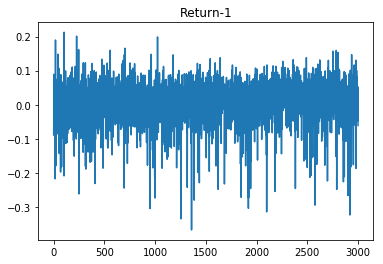

In [42]:
import matplotlib.pyplot as plt
import pandas as pd


ep,return_ = zip(*total_returns_list)
return_ = [y_i-1 for y_i in return_]
return_ = pd.DataFrame(return_)
return_ = return_[return_<=25]

plt.plot(ep,return_)
plt.title('Return-1')
plt.show()

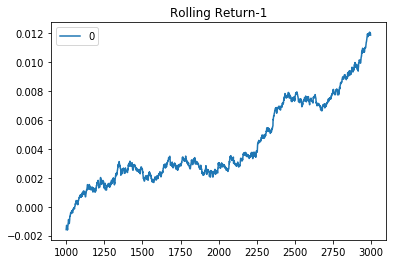

In [43]:
rolling_return = return_.rolling(1000).mean()
rolling_plot = rolling_return.plot(title='Rolling Return-1')

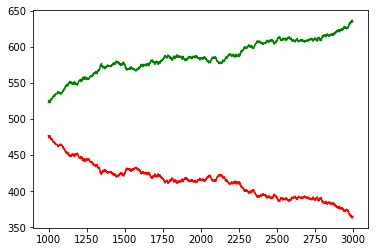

In [44]:
winning_trades = return_.applymap(lambda x: 1 if x>0 else 0)
winning_trades_1000 = winning_trades.rolling(1000).sum()
losing_trades = return_.applymap(lambda x: 1 if x<=0 else 0)
losing_trades_1000 = losing_trades.rolling(1000).sum()

%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(winning_trades_1000.index,winning_trades_1000,color='green')
plt.plot(losing_trades_1000.index,losing_trades_1000,color='red')
plt.show()

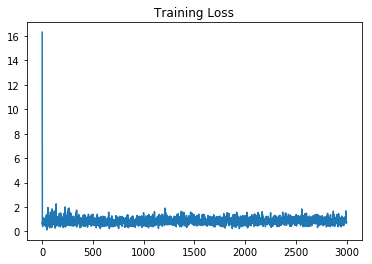

In [45]:
ep,loss = zip(*loss_list)
plt.plot(ep[:],loss[:])
plt.title('Training Loss')
plt.show()

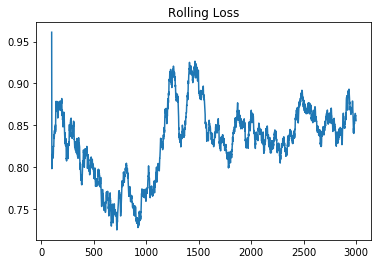

In [46]:
ep,reward = zip(*loss_list)
loss = pd.DataFrame(list(loss))
plt.plot(ep[:],loss.rolling(100).mean())
plt.title('Rolling Loss')
plt.show()

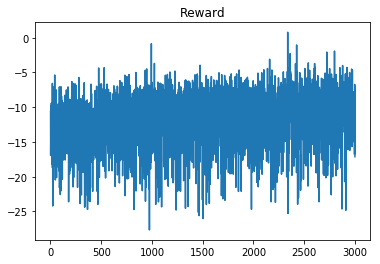

In [47]:
ep,reward = zip(*rewards_list)
plt.plot(ep[:],reward[:])
plt.title('Reward')
plt.show()

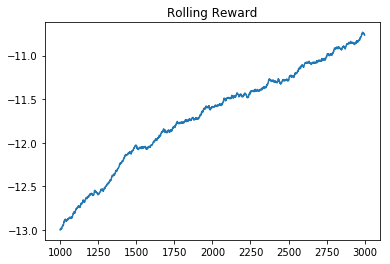

In [48]:
ep,reward = zip(*rewards_list)
reward = pd.DataFrame(list(reward))
rolling_reward = reward.rolling(1000).mean()
plt.plot(ep[:],rolling_reward)
plt.title('Rolling Reward')
plt.show()

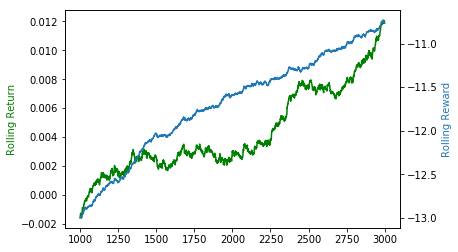

In [49]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(ep[:], rolling_return, 'g-',label='Rolling return')
ax2.plot(ep[:], rolling_reward, label='Rolling reward')

ax1.set_ylabel('Rolling Return', color='g')
ax2.set_ylabel('Rolling Reward', color='C0')

plt.show()

### Testing

Function to run episode with random actions:

In [50]:
def run_random(prices,pos_limit,trading_freq,trading_window,stop_loss_thres,take_prof_thres):
    
    actions = np.random.randint(0,3,size=len(prices))
    action_encoding = {0: 0, 1: 1, 2: -1}
    actions = [action_encoding[action] for action in actions]
    
    pos_log = []
    trade_log = []
    
    stop_loss = False
    take_profit = False
    day_pos=0
    
    pos = 0
    window_counter = 0
    
    for action in actions:
        if action*pos>=0 and stop_loss==False and take_profit==False:
            if abs(pos) < pos_limit:
                trade_log.append(action)
                pos += action #increase existing position or apply action if flat or hold
            else:
                trade_log.append(0) 
        else:
            #trade_log.append(action*(abs(pos)+0))
            trade_log.append(-pos)
            pos = 0 #action #close all existing positions and apply current action          
            
        pos_log.append(pos)
        
        #Store day when last position was openned (for stop_loss & take_profit calc)
        if (pos_log[window_counter]!=0) and (pos_log[window_counter-1]==0):        
            day_pos = window_counter
        
        #Calculate next day's open over all previous days' open (for stop_loss & take_profit trigger)
        if window_counter < trading_window-1:
            open_open_return = prices.iloc[window_counter+1]['Open'] / prices.iloc[:window_counter+1]['Open']
        else:
            open_open_return = prices.iloc[window_counter]['Close'] / prices.iloc[:window_counter+1]['Open']
        #Calculate active return (marked at Open_t+1)
        if pos != 0:
            today_return = [1+trade_log[i]*(open_open_return[i]-1) for i in range(day_pos,window_counter+1)]
            active_return = np.prod(today_return)
        else:
            active_return = 1   
        
        
        #Check stop_loss and take_profit
        stop_loss = True if active_return < stop_loss_thres else False
        take_profit = True if active_return > take_prof_thres else False
        
        
        window_counter += trading_freq
    
    close_open_returns = prices.iloc[-1]['Close'] / prices.iloc[:window_counter+1]['Open']
    close_returns = [1+trade_log[i]*(close_open_returns[i]-1) for i in range(len(close_open_returns))]
                
    total_return = np.prod(close_returns)
    
    return total_return
    

Function to run episode with trained model and random model:

In [51]:
def run_episode(env,pos_limit,trading_freq,trading_window,stop_loss_thres,take_prof_thres,raw_data,verbose=1): 
    import tensorflow as tf

    tf.Graph()
    saver = tf.train.Saver(tf.global_variables())
    tf.logging.set_verbosity(tf.logging.ERROR)

    actions = [] # actions that the agent selects
    rewards = [] # obtained rewards
    state = env.reset()
    i=0

    with tf.Session() as sess:
        saver.restore(sess, "checkpoints/trader.ckpt")
        while True:
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)

            state, reward, done, info_log = env.step(action) 
            rewards.append(reward)
            actions.append(action)
            #print('Day {:.0f} Open_day = {:.2f}, Close_epi = {:.2f}, Close_epi/Open_day = {:2f}, Trade = {:.0f}, Daily Return = {:.2f}'.format(i,info_log['prices'].iloc[i]['Open'],info_log['prices'].iloc[-1]['Close'],info_log['close_open_returns'][i],info_log['trades'][i],info_log['daily_return']))
            i += 1
            if done:
                break

    #run episode with random actions
    random_return = run_random(info_log['prices'],pos_limit,trading_freq,trading_window,stop_loss_thres,take_prof_thres)
                
    plt_df = info_log['prices']
    plt_df['Trades'] = info_log['trades']
    plt_df['Pos'] = info_log['pos']
    plt_df['Actions'] = info_log['actions']
    stop_loss_log = info_log['stop_loss_log']
    
    if verbose == 1 : #and info_log['total_return'] <= 1:
        print('Return: {:.3f}'.format(info_log['total_return']))
        print('Random return: {:.3f}'.format(random_return))
    
        %matplotlib inline
        import matplotlib.pyplot as plt

        fig = plt.figure(figsize=(15,3))
        #Plot Prices
        plt.xticks(rotation=90)
        plt.grid(color='k', linestyle='--', linewidth=0.1)
        
        start_date = pd.to_datetime(plt_df.index[0]).strftime('%Y-%m-%d')
        end_date = pd.to_datetime(plt_df.index[-1]).strftime('%Y-%m-%d')
        
        #Plot some days before the start of the episode to see recent trends
        start_date_ext = (pd.to_datetime(plt_df.index[0]) - pd.to_timedelta(10,'d')).strftime('%Y-%m-%d')
        plt.plot(raw_data.loc[start_date_ext:start_date].index,raw_data.loc[start_date_ext:start_date].Open,'--',color='gray')
        
        plt.plot(raw_data.loc[start_date:end_date].index,raw_data.loc[start_date:end_date].Open,color='black')
        
        plt.ylim(min(raw_data.loc[start_date_ext:end_date].Open)*0.95, max(raw_data.loc[start_date_ext:end_date].Open)*1.05)
               
        #Plot Buys
        plt.scatter(plt_df[plt_df['Trades']>0].index,plt_df[plt_df['Trades']>0].Open,
                    color='green',marker='^',s=100,zorder=3)
        #Plot Sells
        plt.scatter(plt_df[plt_df['Trades']<0].index,plt_df[plt_df['Trades']<0].Open,
                    color='red',marker='v',s=100,zorder=3)

        for i, txt in enumerate(plt_df.Trades):
            if stop_loss_log[i]:
                    txt = str(txt) + ' (S)'
            if txt !=0:
                plt.annotate(txt, (plt_df.index[i], plt_df.Open[i]+0.008*plt_df.Open[i]))
                plt.annotate('('+str(plt_df.Pos[i])+')', (plt_df.index[i], plt_df.Open[i]-0.015*plt_df.Open[i]))

        plt.show()
    return info_log['total_return'], random_return

Set up environment for testing:

In [55]:
import gym
import gym_market
import numpy as np
import imp

ticker = 'ba.us'
trading_window = 21
pos_limit = 2
trading_freq = 1

stop_loss_thres = 0.98
take_prof_thres = 1.04

kwargs = {'pos_limit': pos_limit,
                  'trading_window': trading_window,
                  'trading_freq': trading_freq,
                  'ticker': ticker,
                  'stop_loss_thres': stop_loss_thres,
                  'take_prof_thres': take_prof_thres,
                  'features': features_test, 
                  'raw_data':raw_data_test}

env = gym.make('market-v0', **kwargs)

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

Number of possible actions: 3


Run tests:

Return: 0.930
Random return: 1.059


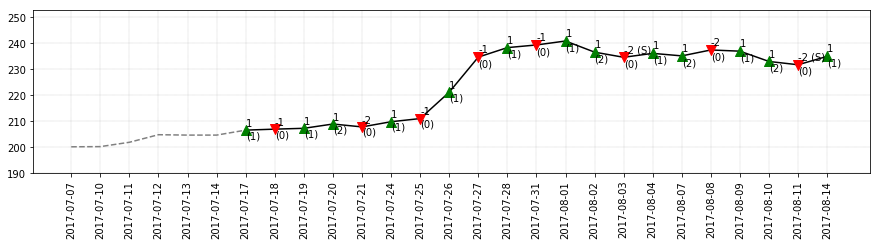

Return: 0.988
Random return: 0.919


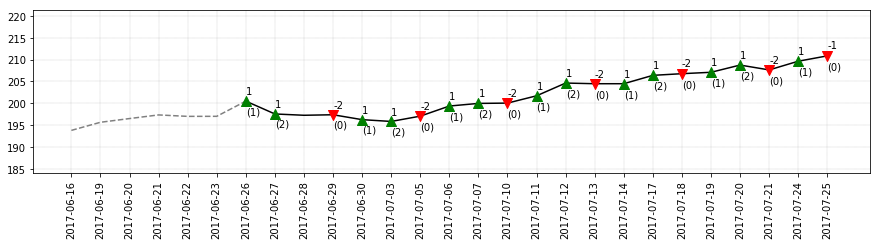

Return: 1.027
Random return: 1.044


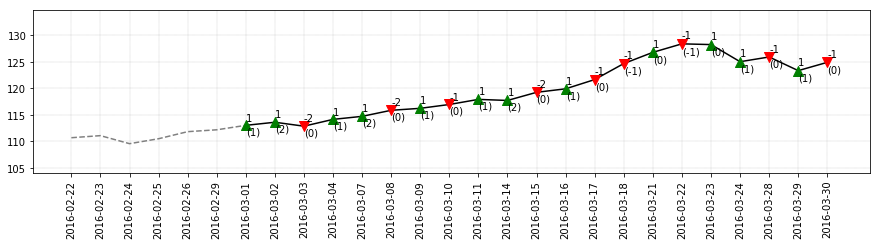

Return: 1.053
Random return: 0.878


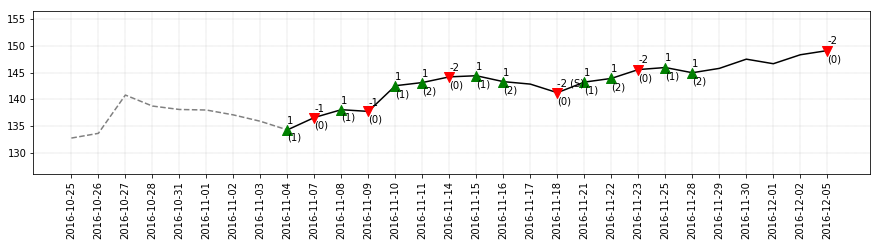

Return: 1.032
Random return: 0.943


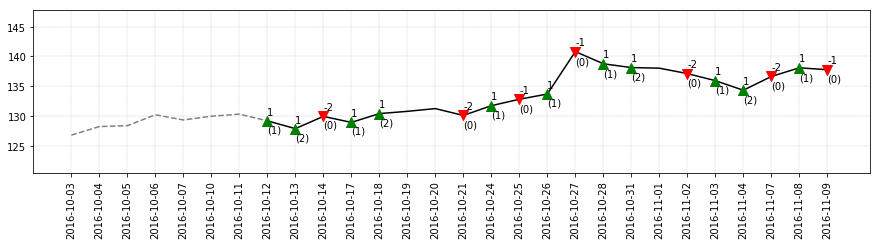

Return: 0.993
Random return: 0.878


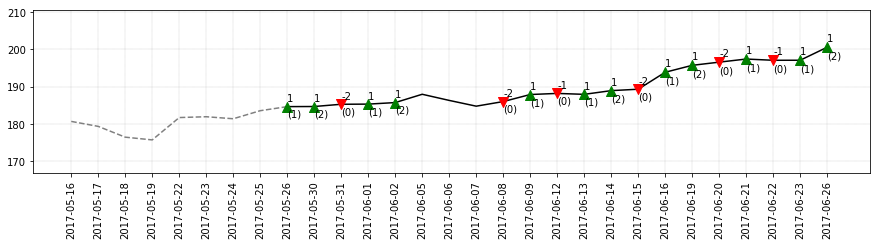

Return: 1.062
Random return: 1.009


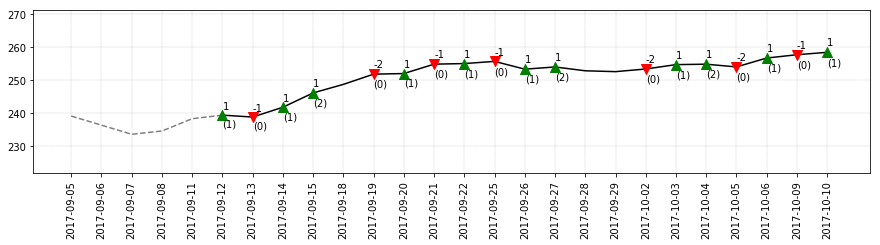

Return: 1.027
Random return: 1.153


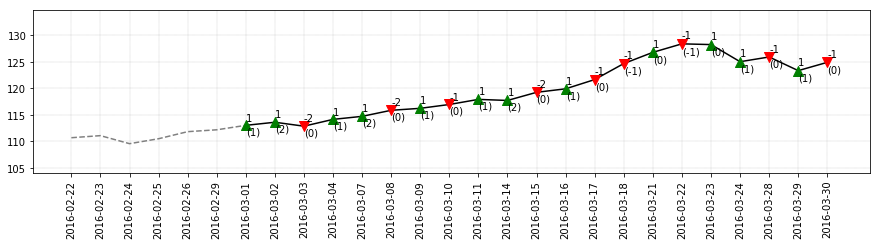

Return: 1.100
Random return: 1.019


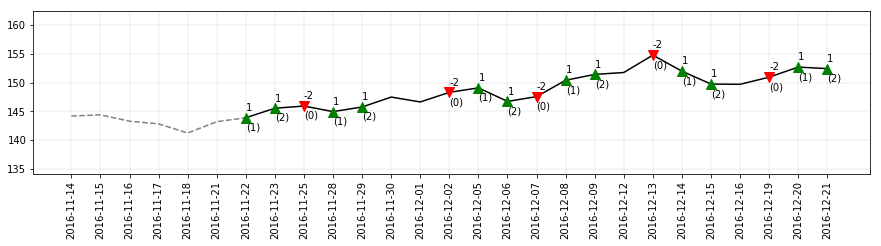

Return: 1.052
Random return: 1.004


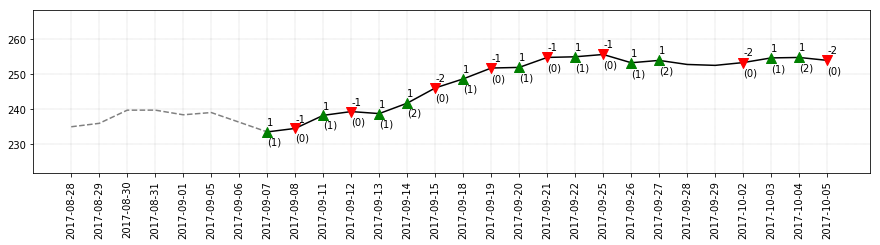

Return: 1.016
Random return: 0.847


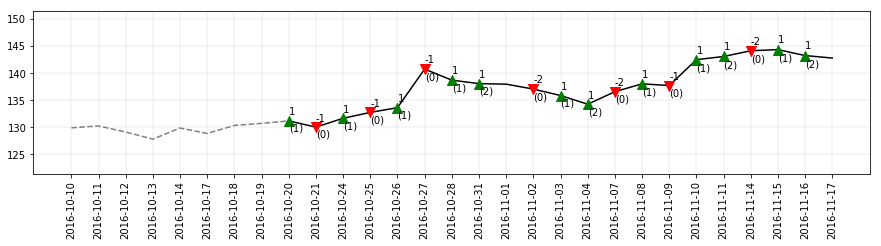

Return: 1.163
Random return: 0.955


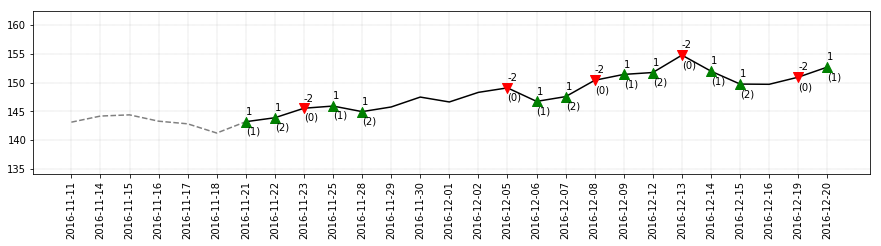

Return: 1.034
Random return: 0.987


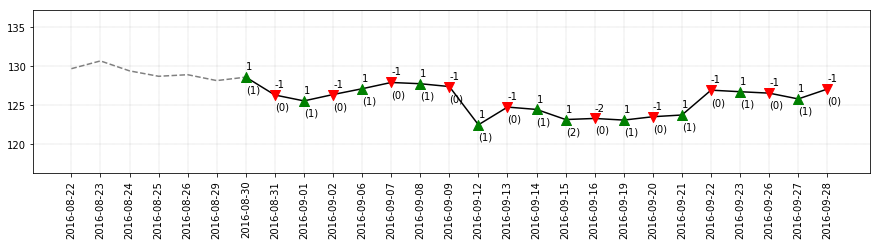

Return: 0.904
Random return: 1.126


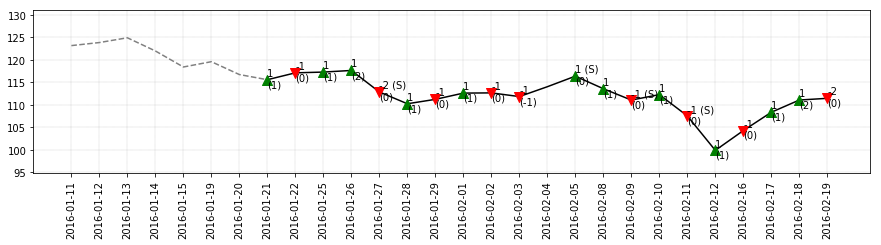

Return: 1.073
Random return: 1.002


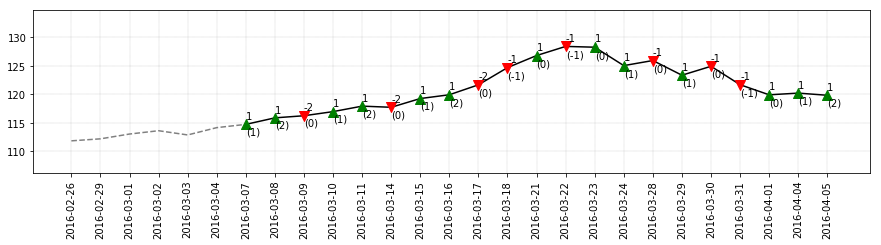

Return: 1.009
Random return: 1.092


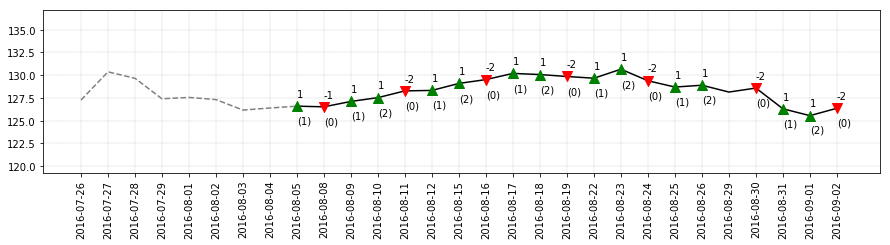

Return: 1.078
Random return: 1.045


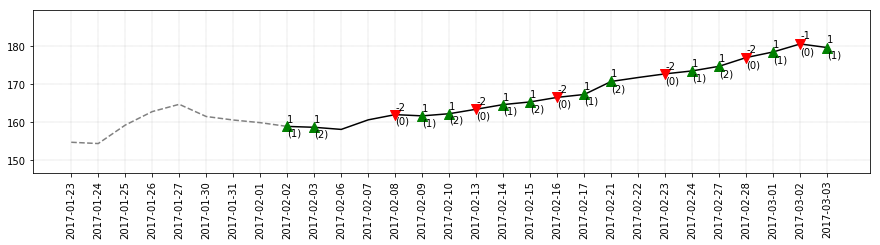

Return: 1.039
Random return: 0.917


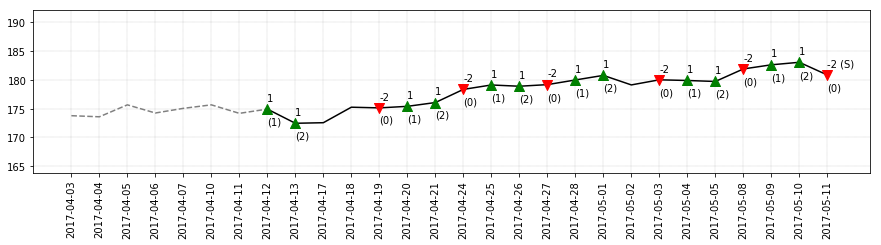

Return: 1.057
Random return: 0.964


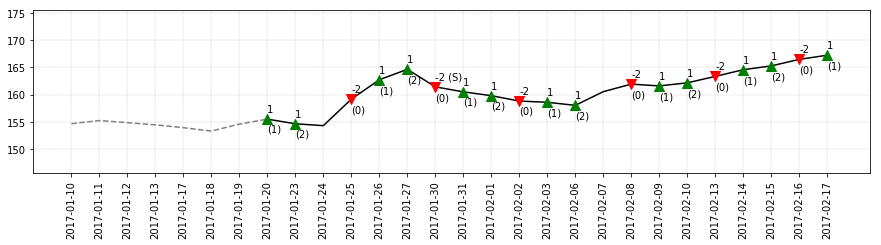

Return: 1.057
Random return: 1.116


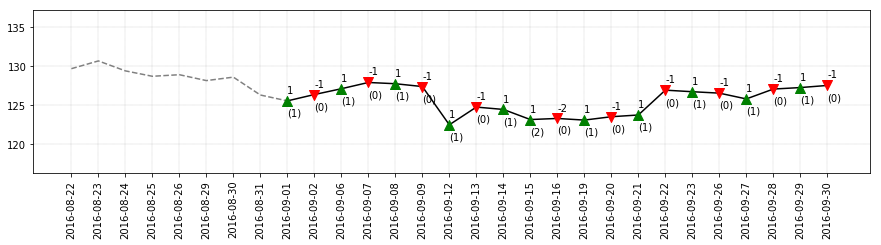

Return: 0.926
Random return: 1.155


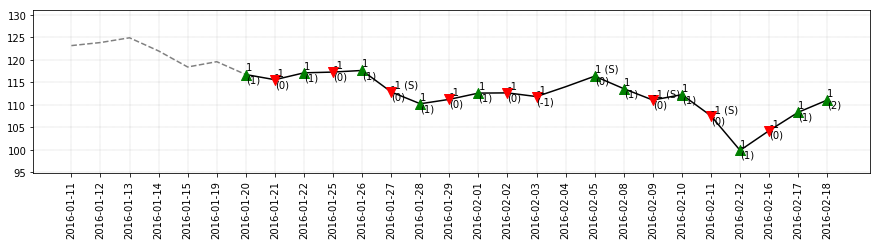

Return: 1.018
Random return: 0.886


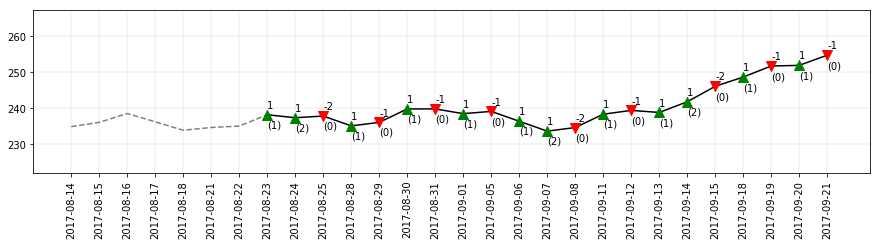

Return: 1.089
Random return: 0.846


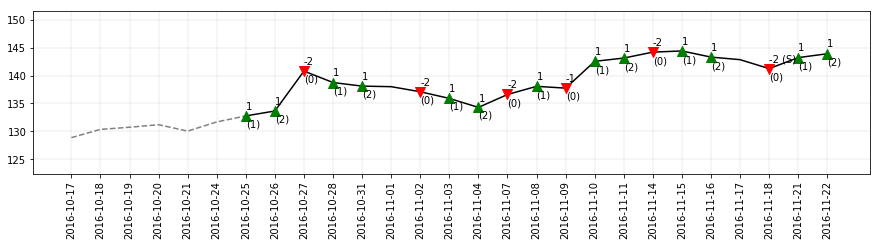

Return: 0.980
Random return: 0.992


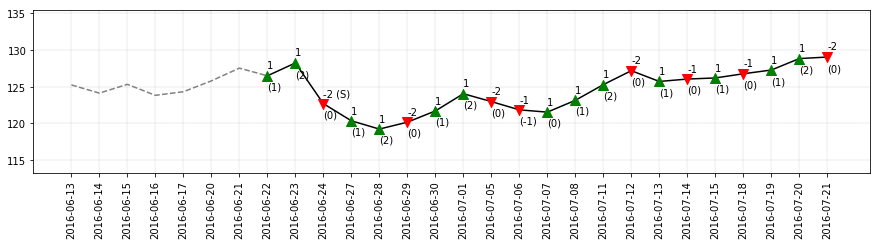

Return: 1.045
Random return: 0.936


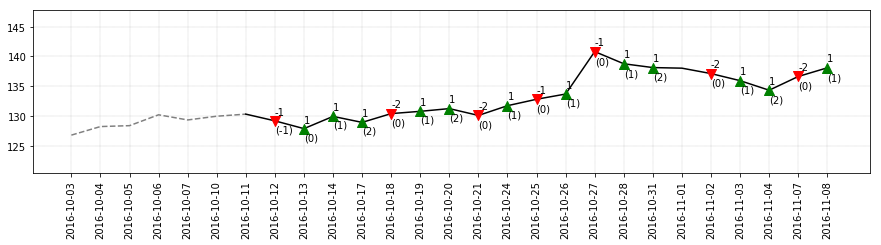

Return: 0.954
Random return: 0.965


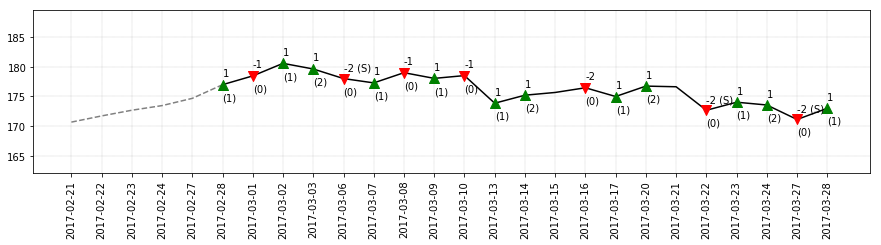

Return: 0.845
Random return: 0.906


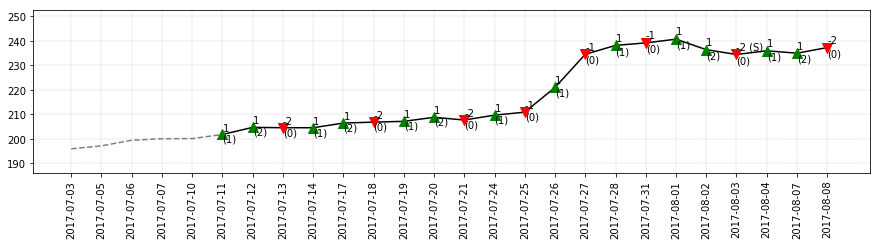

Return: 1.043
Random return: 0.972


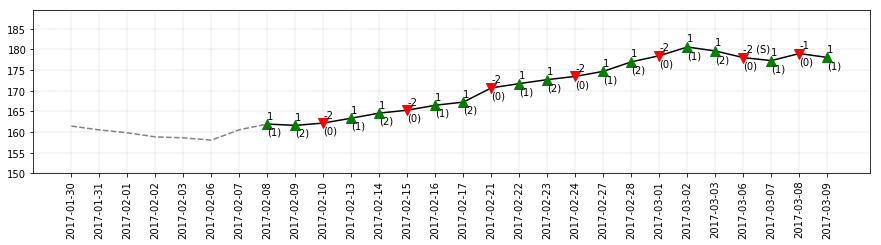

Return: 0.953
Random return: 1.030


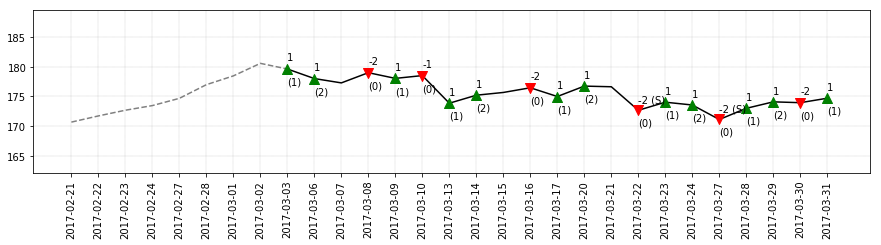

Return: 1.052
Random return: 0.971


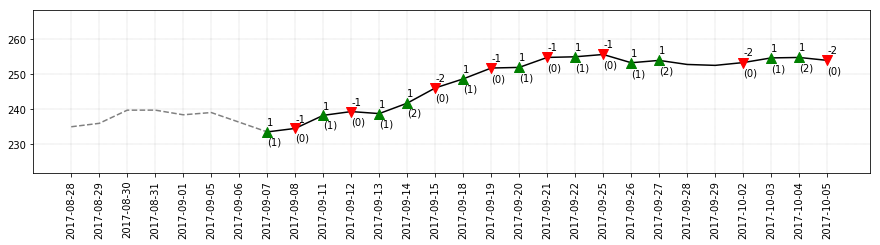

Return: 0.980
Random return: 1.048


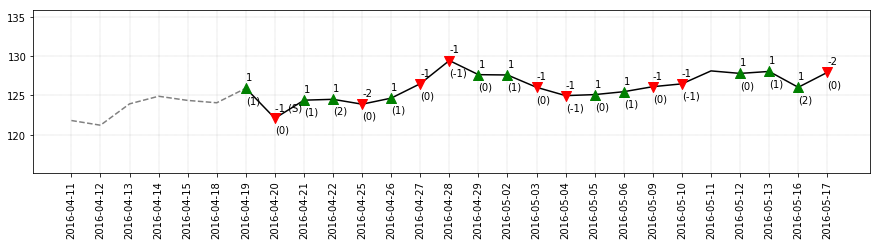

Return: 1.049
Random return: 0.975


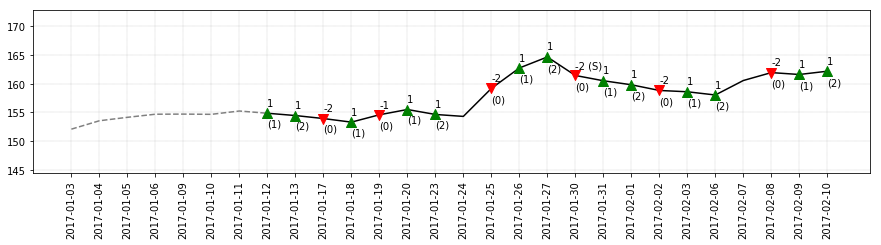

Return: 1.020
Random return: 0.989


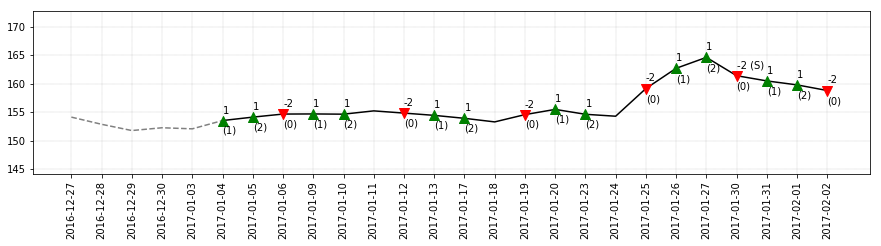

Return: 0.980
Random return: 1.004


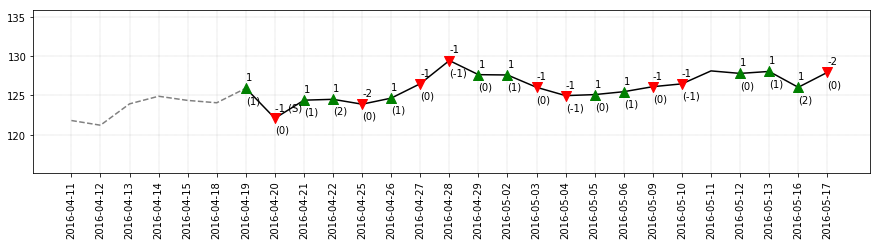

Return: 0.980
Random return: 0.915


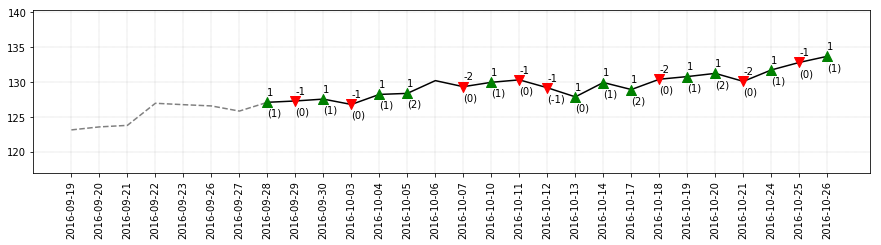

Return: 1.027
Random return: 1.013


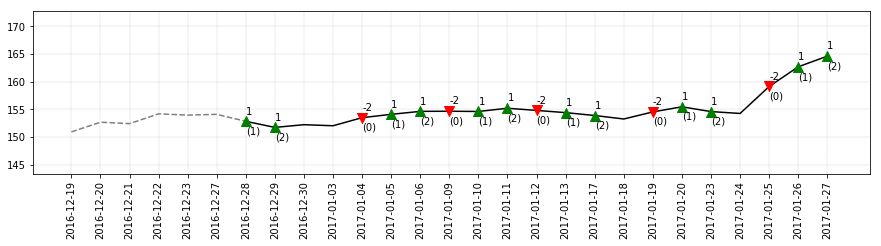

Return: 1.014
Random return: 0.953


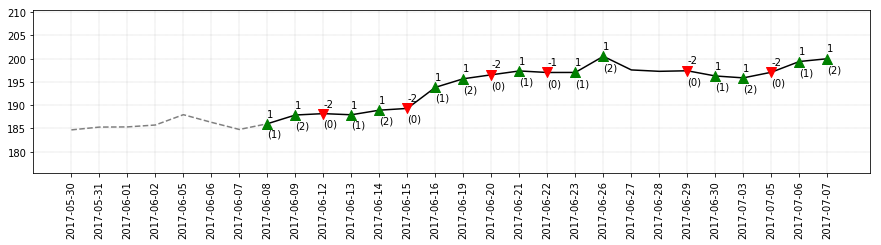

Return: 1.037
Random return: 1.064


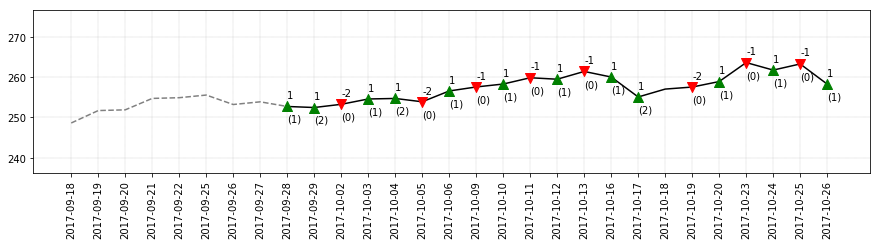

Return: 0.964
Random return: 1.032


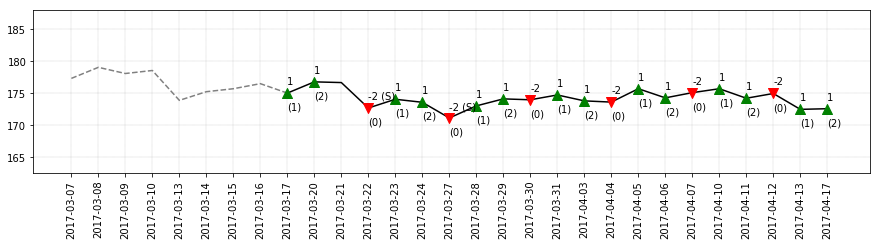

Return: 1.063
Random return: 1.000


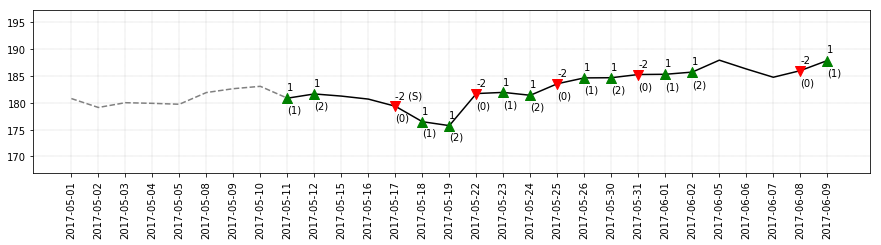

Return: 1.046
Random return: 1.116


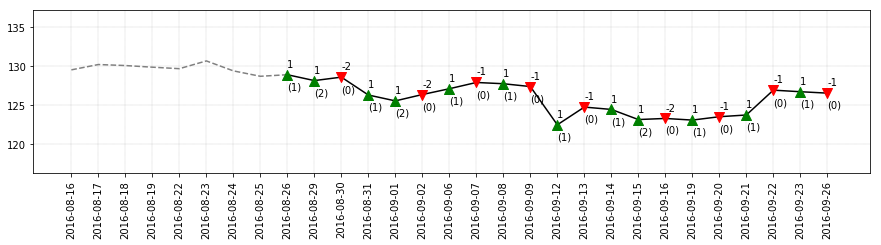

Return: 1.070
Random return: 1.080


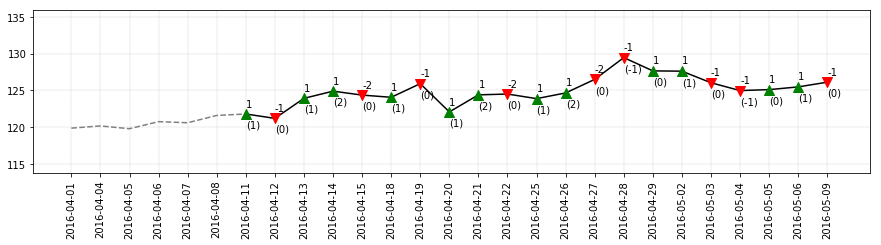

Return: 1.016
Random return: 0.912


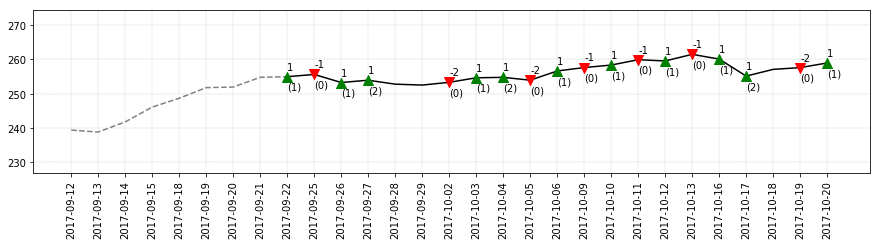

Return: 0.961
Random return: 0.944


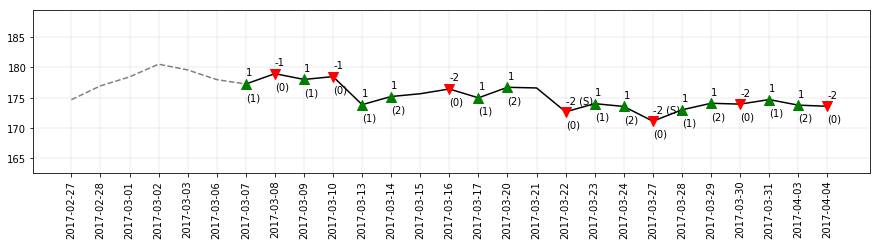

Return: 0.980
Random return: 0.937


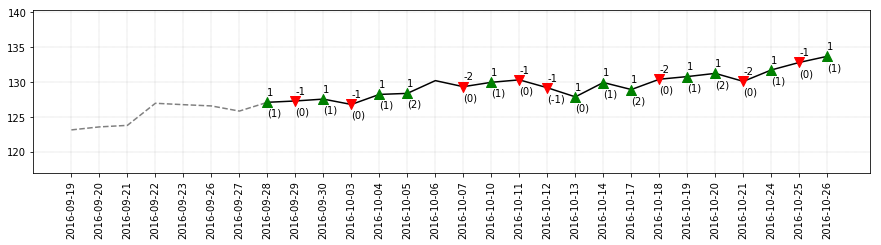

Return: 0.914
Random return: 0.877


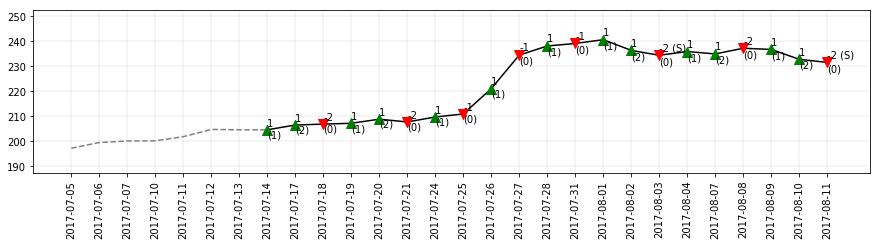

Return: 0.991
Random return: 0.980


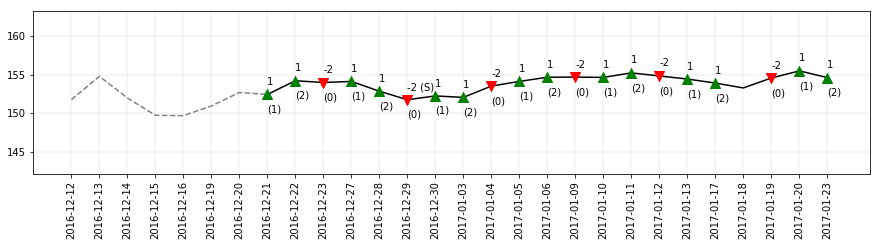

Return: 1.025
Random return: 1.017


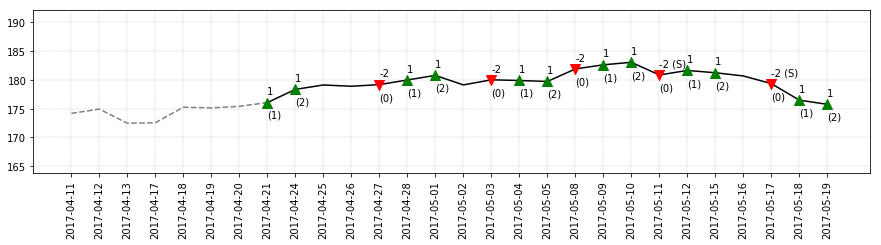

Return: 1.029
Random return: 1.058


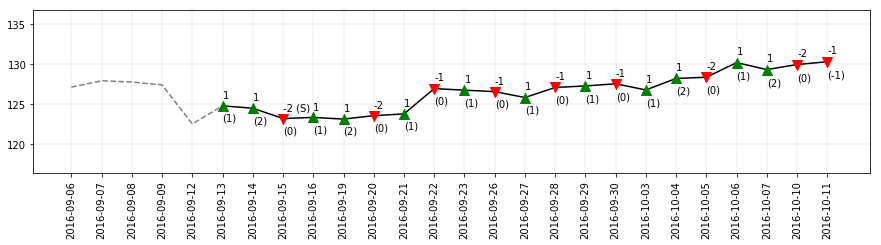

Return: 0.999
Random return: 0.989


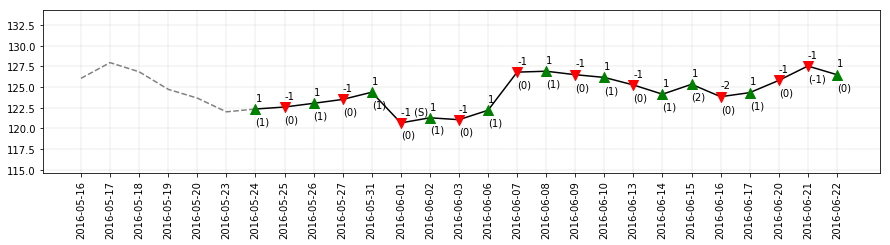

Return: 1.002
Random return: 1.059


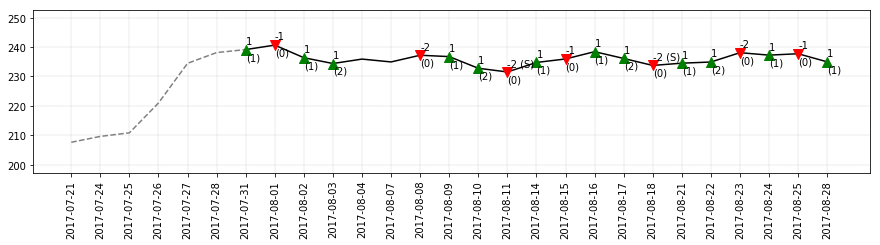

Return: 1.049
Random return: 0.949


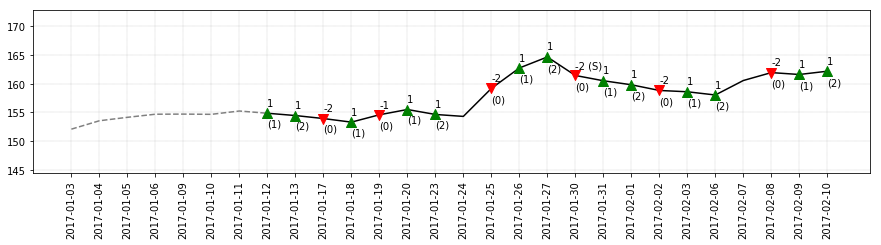

Return: 1.010
Random return: 0.966


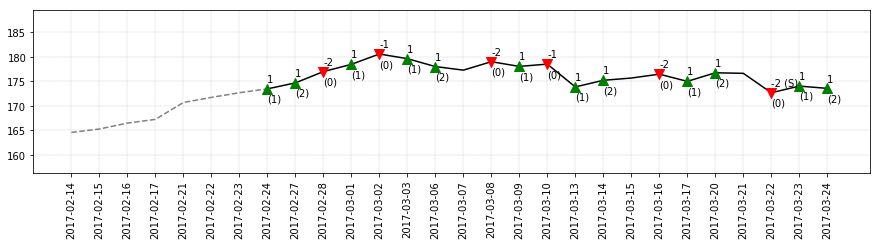

Return: 1.029
Random return: 1.002


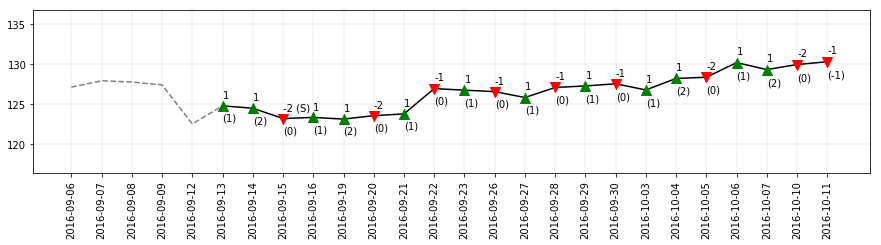

Return: 0.986
Random return: 0.974


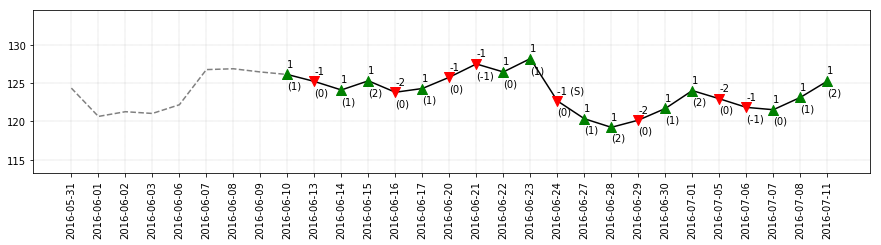

Return: 0.938
Random return: 0.918


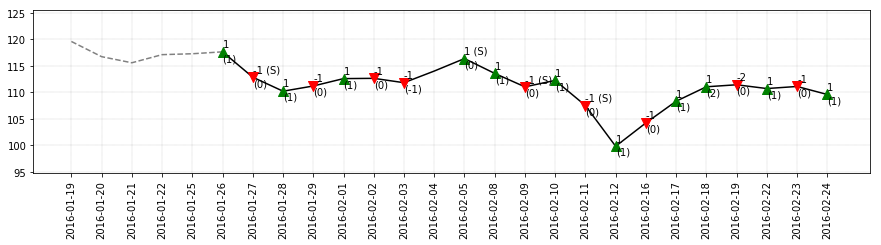

Return: 1.015
Random return: 1.018


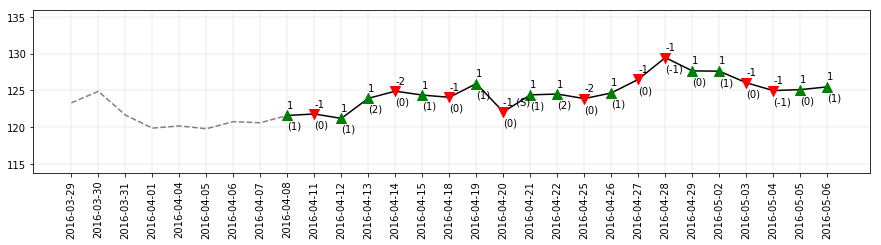

Return: 1.042
Random return: 1.007


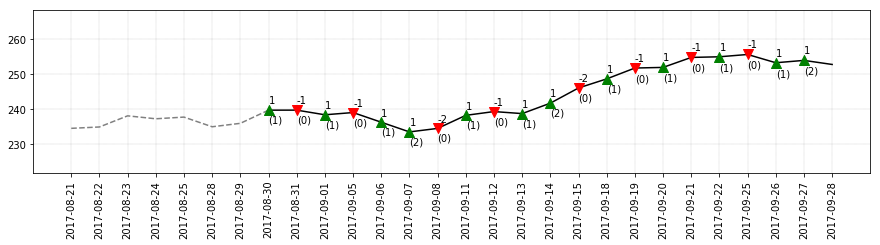

Return: 1.013
Random return: 0.984


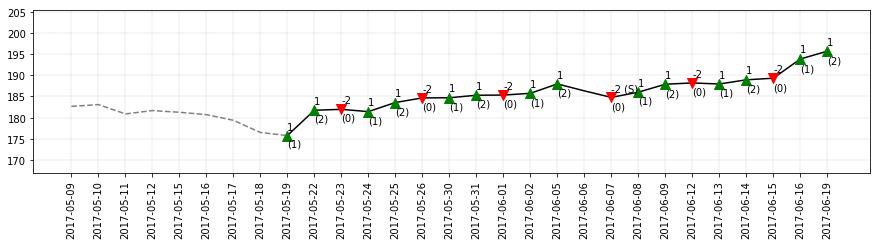

Return: 1.043
Random return: 0.984


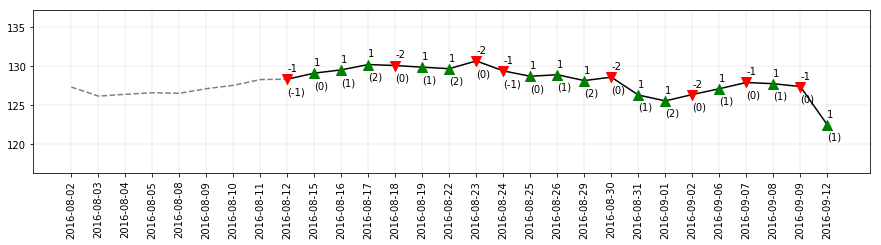

Return: 0.955
Random return: 0.977


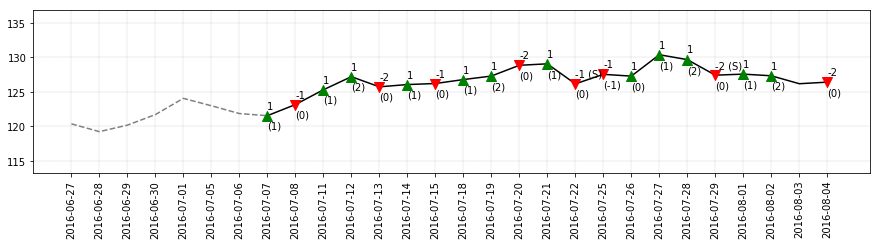

Return: 0.981
Random return: 0.989


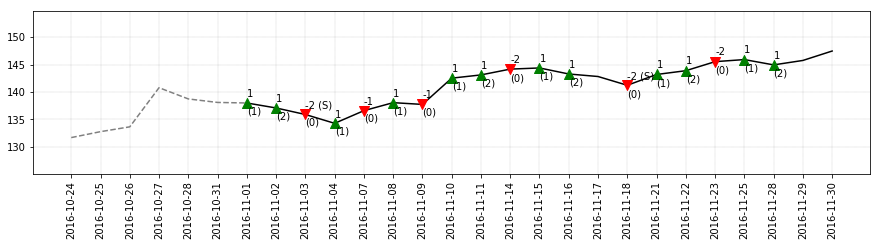

Return: 0.763
Random return: 0.844


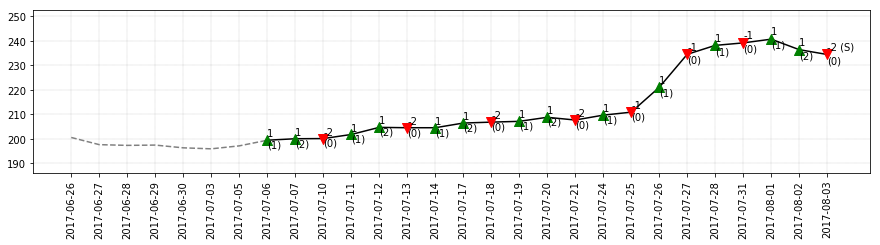

Return: 1.095
Random return: 1.024


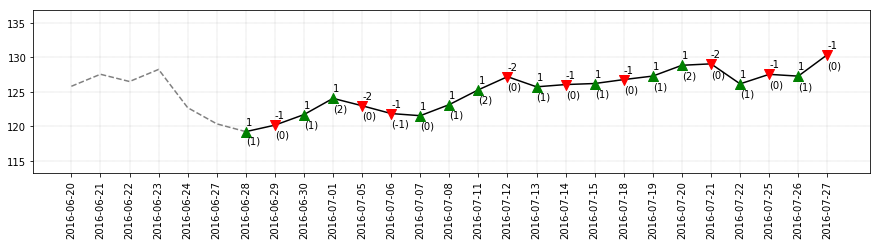

Return: 1.076
Random return: 0.985


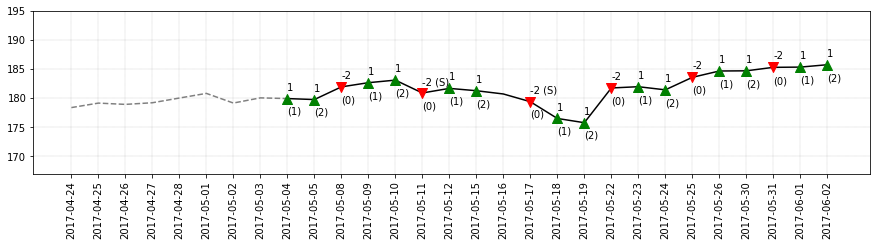

Return: 1.030
Random return: 0.945


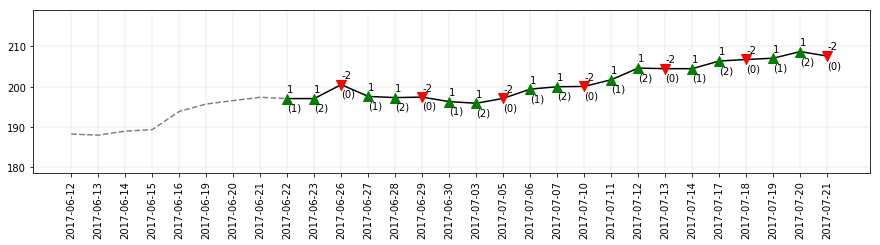

Return: 1.049
Random return: 0.964


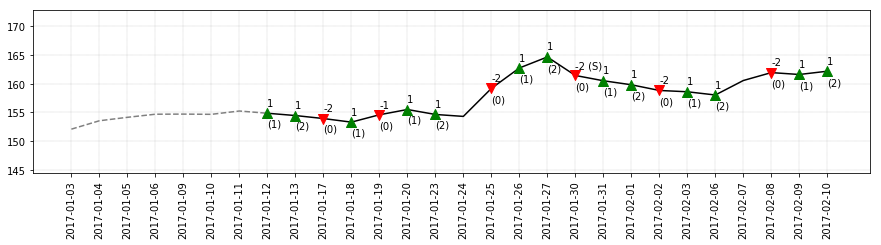

Return: 1.028
Random return: 1.069


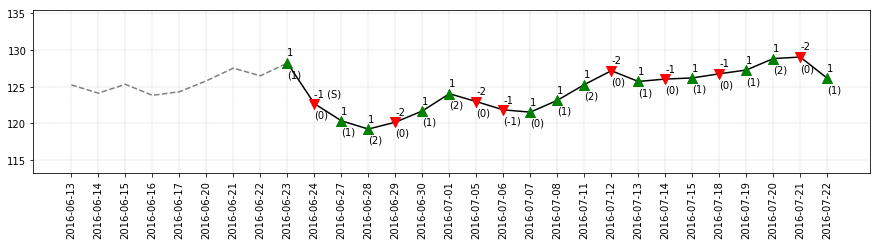

Return: 1.043
Random return: 1.090


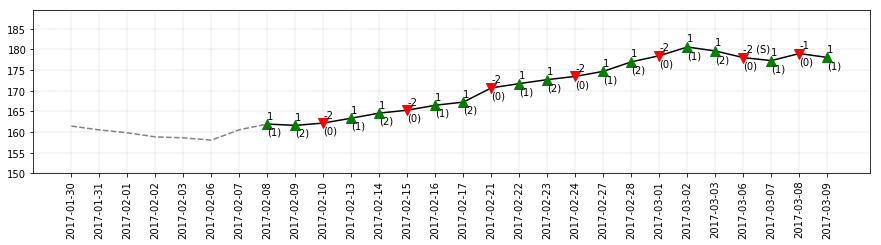

Return: 1.059
Random return: 0.968


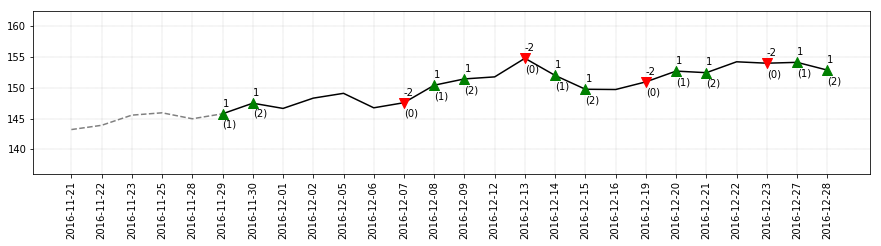

Return: 1.059
Random return: 0.956


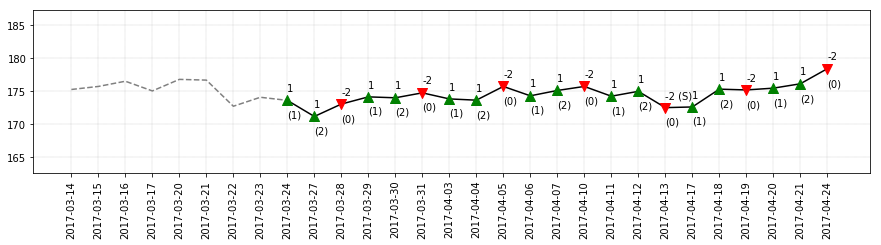

Return: 1.056
Random return: 1.082


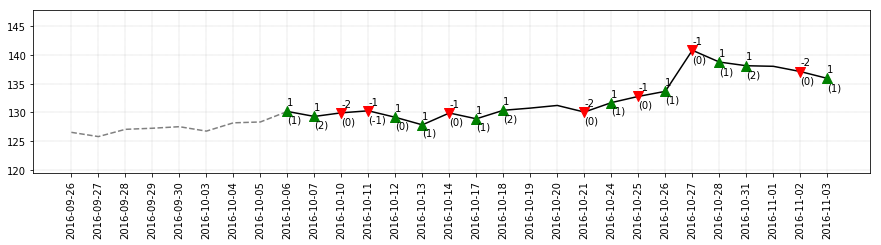

Return: 1.029
Random return: 1.008


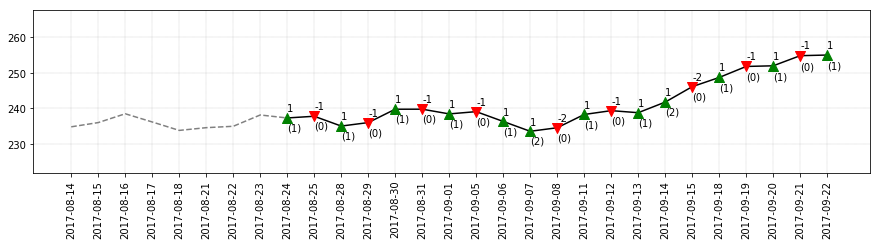

Return: 0.953
Random return: 1.029


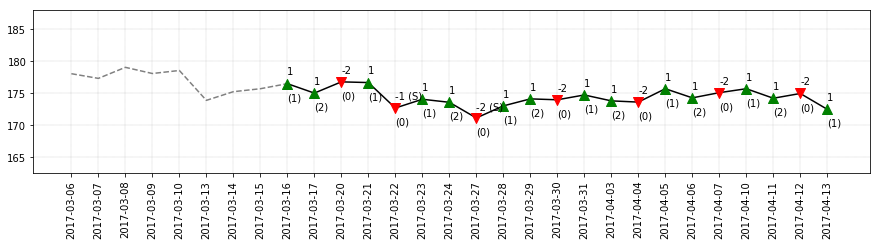

Return: 1.063
Random return: 1.001


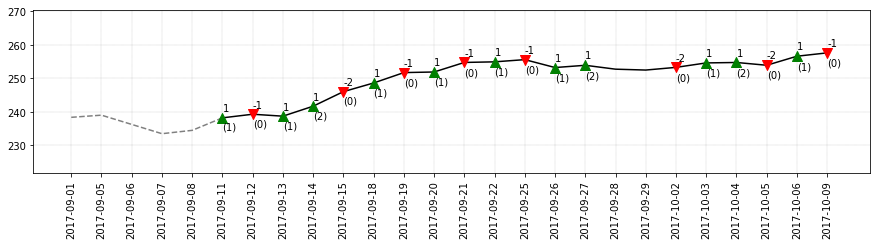

Return: 1.020
Random return: 1.037


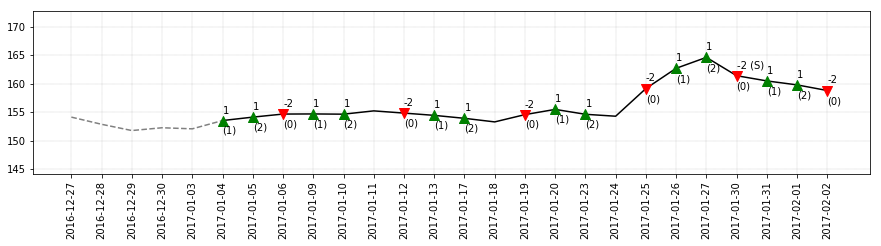

Return: 1.001
Random return: 0.998


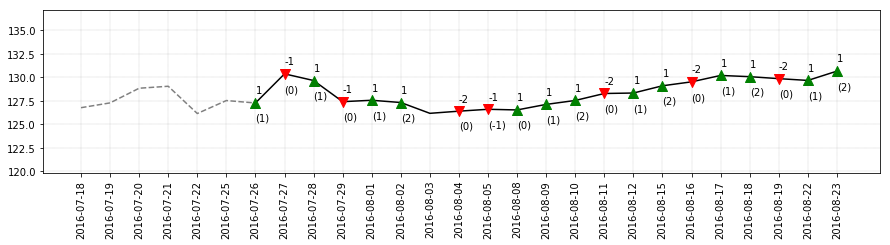

Return: 0.953
Random return: 1.007


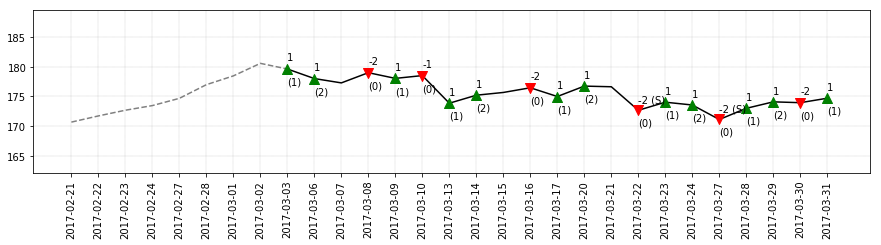

Return: 1.083
Random return: 1.063


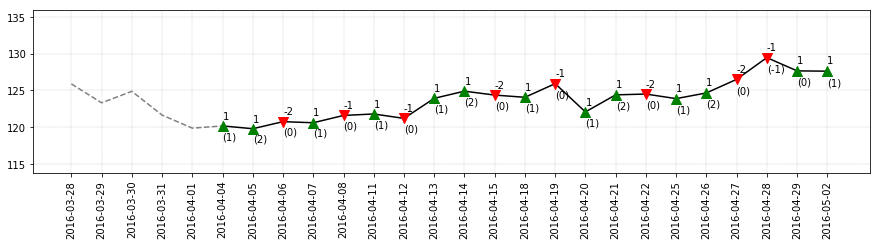

Return: 1.019
Random return: 1.053


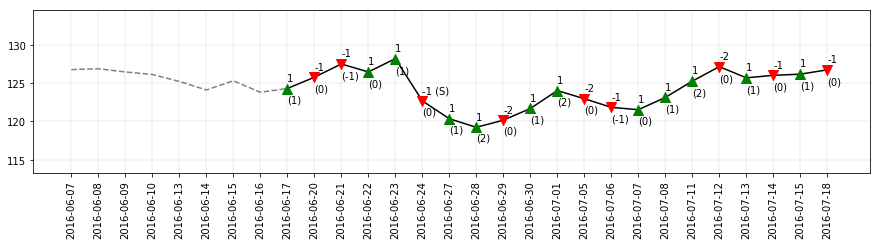

Return: 0.996
Random return: 1.052


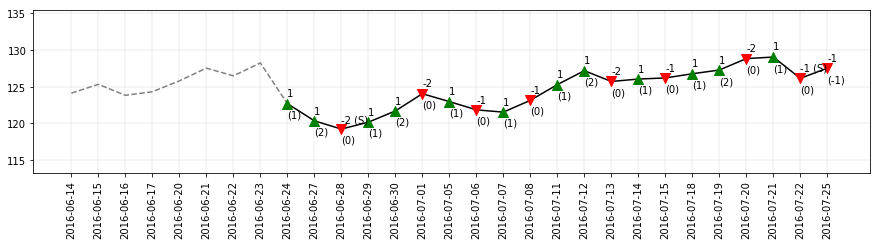

Return: 1.048
Random return: 0.953


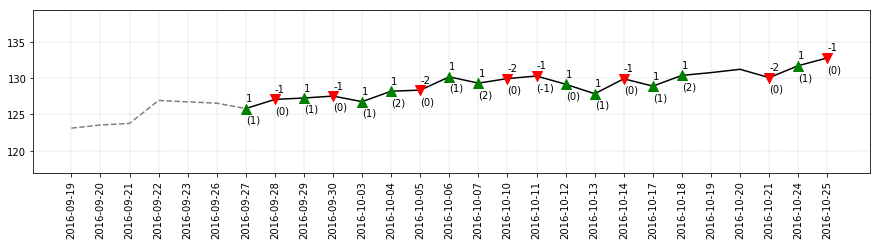

Return: 1.008
Random return: 0.966


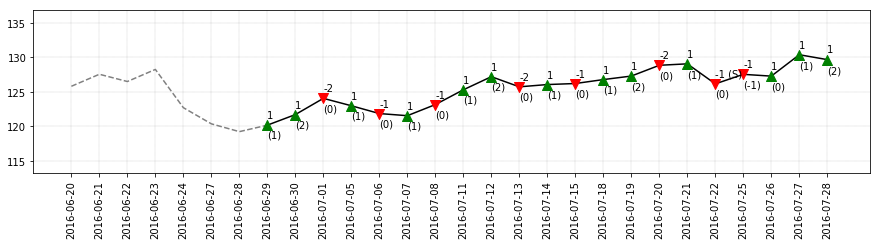

Return: 1.028
Random return: 0.988


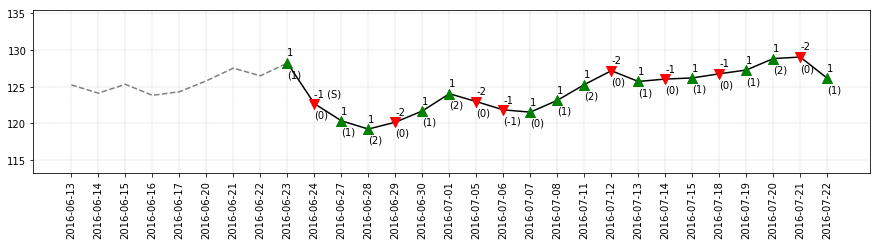

Return: 1.013
Random return: 1.019


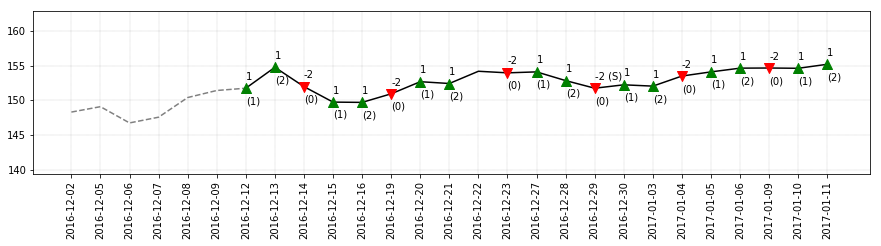

Return: 0.992
Random return: 1.002


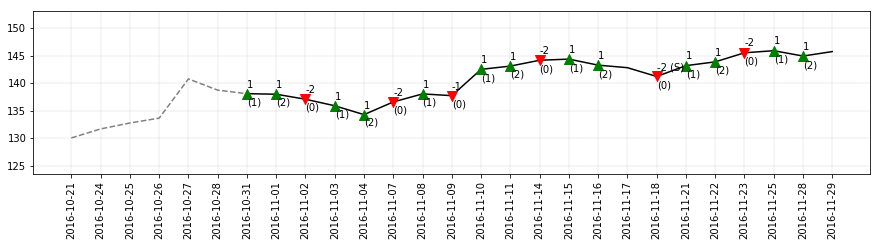

Return: 0.622
Random return: 0.818


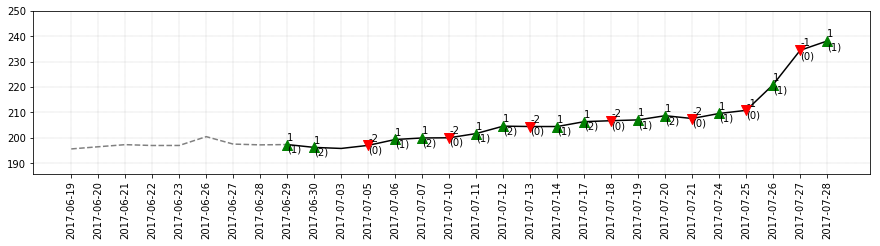

Return: 1.044
Random return: 0.952


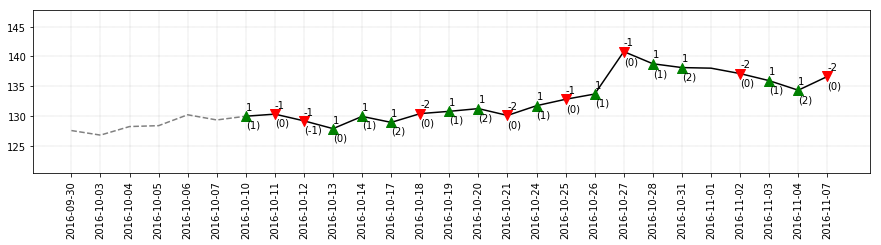

Return: 1.051
Random return: 1.047


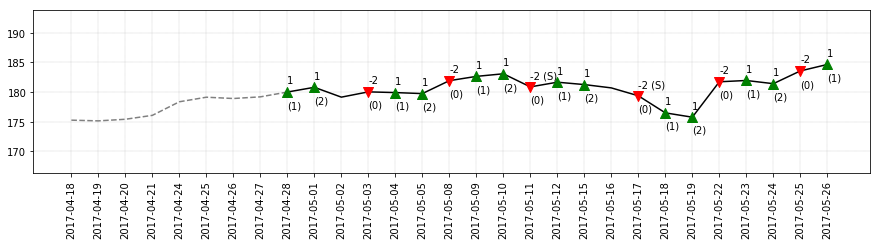

Return: 0.964
Random return: 1.009


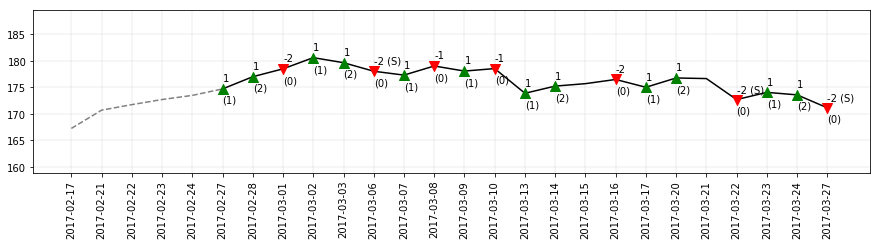

Return: 1.004
Random return: 0.954


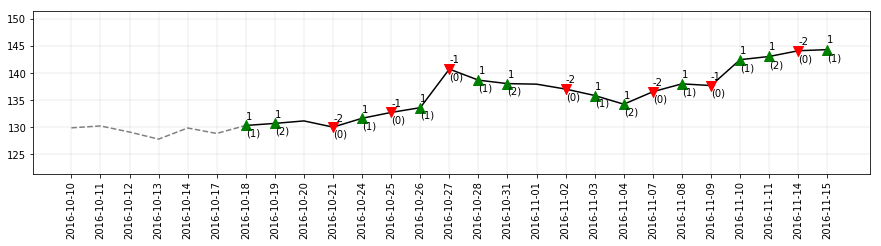

Return: 1.057
Random return: 1.108


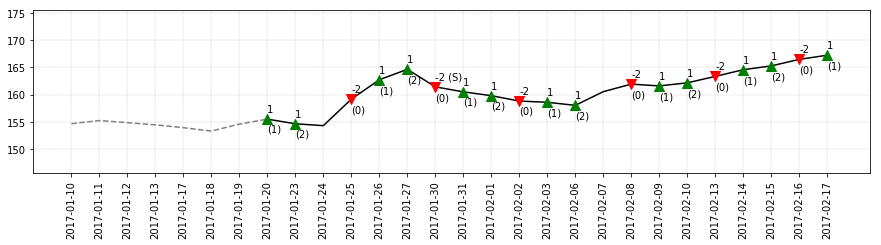

Return: 1.018
Random return: 0.999


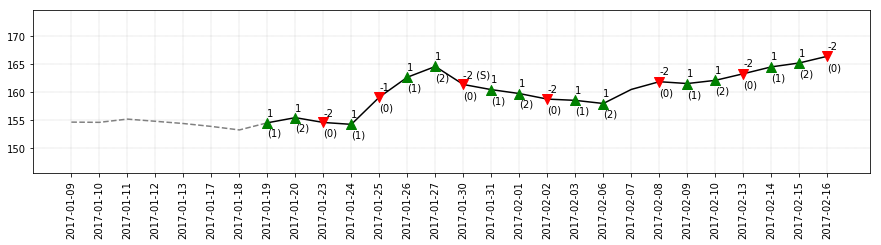

Return: 1.046
Random return: 0.861


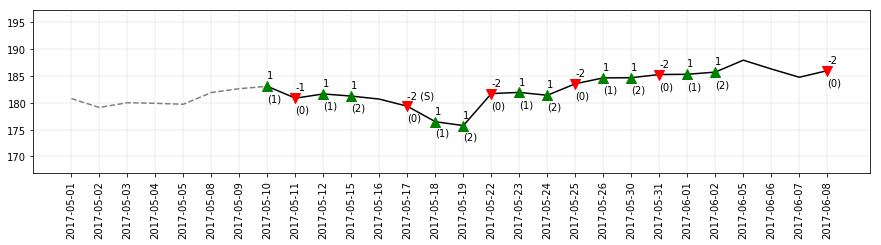

Return: 1.011
Random return: 0.995


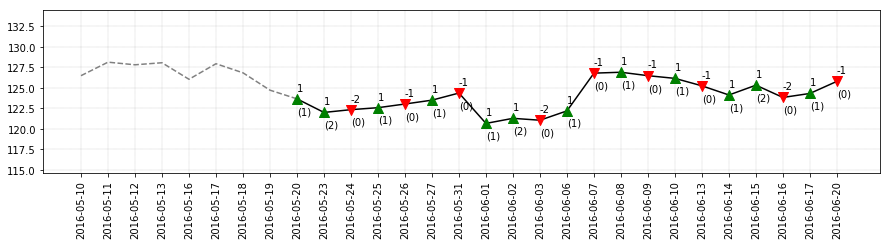

Return: 0.992
Random return: 1.006


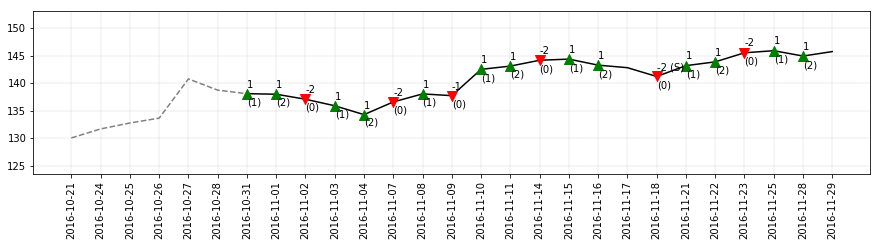

Return: 1.092
Random return: 0.990


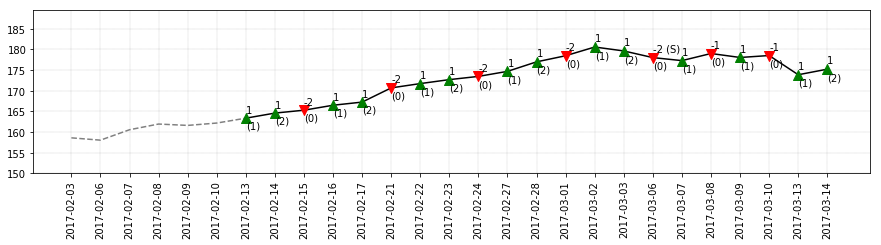

Return: 1.052
Random return: 1.083


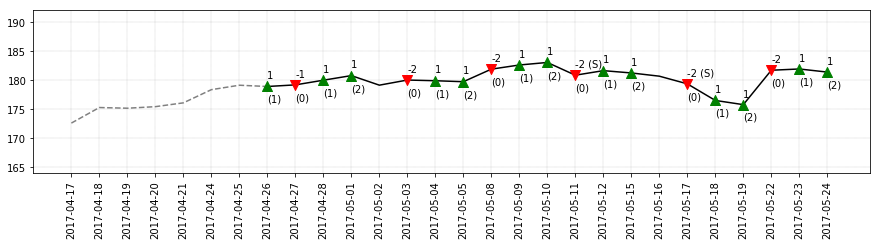

Return: 1.030
Random return: 0.955


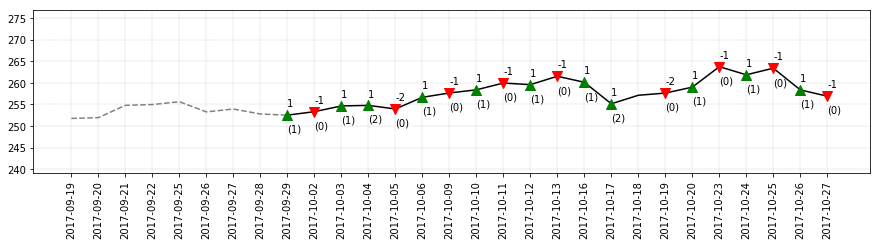

Return: 1.009
Random return: 1.018


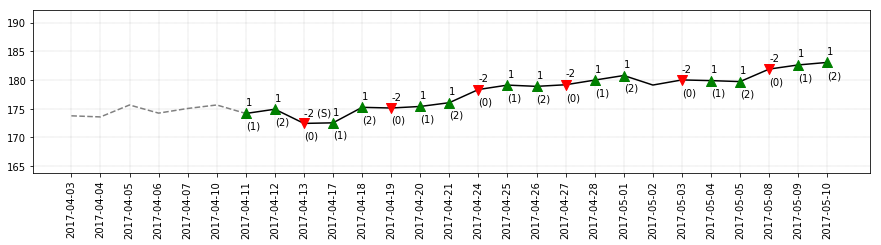

In [56]:
episode_count = 100

returns = []
random_returns = []

for i in range(episode_count):
    return_, random_return = run_episode(env,pos_limit,trading_freq,trading_window,stop_loss_thres,take_prof_thres,raw_data_test,verbose=1)
    returns.append(return_)
    random_returns.append(random_return)

In [57]:
print('Average RL return ({:d} episodes): {:.3f}'.format(episode_count, np.mean(returns)))
print('Average random return ({:d} episodes): {:.3f}'.format(episode_count, np.mean(random_returns)))

Average RL return (100 episodes): 1.013
Average random return (100 episodes): 0.992
